<a id="contents"></a><br>
# Contents
1. [Set up environments](#workEnv)     
    1. [R](#workEnvR) 
    2. [Python](#workEnvPyth)
2. [Clean up environmental data](#cleanupEnv)
3. [Clean up community data](#cleanupCom)
    1. [Mock community controls](#MCC)
    2. [Single species control](#SSC)
    3. [Corrections for contamination and OTU clustering](#otuClust)
    4. [Make community matrix for general use, decide minimum abundances](#minAbund)
4. [Make a map of the sampling effort of Carbon4D](#baseMap)
5. [Alpha diversity](#alphaDiversity)
6. [Beta-diversity ](#betaDiversity)
    2. [Ordinations](#ord)
    1. [Community turnover](#comTurnover)
8. [Gamma diversity](#gammaDiversity)
9. [Respiration](#resp)
    1. [Respiration spatial trends](#respMap)
10. [Define spatial variables](#pcnm)


<a id="workEnv"></a><br>
## Set up environments

<a id="workEnvR"></a><break>
### Working environment R

We'll use both R and python a lot. What we need for R:

In [1]:
library(vegan)
library(phyloseq)
library(ape)
library(ade4)
library(adespatial)
library(sp)
library(spdep)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-4

Registered S3 methods overwritten by 'adegraphics':
  method         from
  biplot.dudi    ade4
  kplot.foucart  ade4
  kplot.mcoa     ade4
  kplot.mfa      ade4
  kplot.pta      ade4
  kplot.sepan    ade4
  kplot.statis   ade4
  scatter.coa    ade4
  scatter.dudi   ade4
  scatter.nipals ade4
  scatter.pco    ade4
  score.acm      ade4
  score.mix      ade4
  score.pca      ade4
  screeplot.dudi ade4

Registered S3 method overwritten by 'spdep':
  method   from
  plot.mst ape 

Registered S3 methods overwritten by 'adespatial':
  method             from       
  plot.multispati    adegraphics
  print.multispati   ade4       
  summary.multispati ade4       


Attaching package: ‘adespatial’


The following object is masked from ‘package:ade4’:

    multispati


Loading required package: spData

To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spD

On local pc:

In [2]:
spatDir <- "/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis/"
sulariDataDir="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/"


On lab server:

In [2]:
spatDir <- "/media/vol1/daniel/sulariArne/soilAnalysis/fichtelgebirgeSoils/spatialAnalysis/"
sulariDataDir="/media/vol1/daniel/sulariArne/soilAnalysis/fichtelgebirgeSoils/sulariData/"

And on both:

In [3]:
setwd(spatDir)
# data that we usually need:
load(paste0(sulariDataDir,"sulariPhyloseqObject.rda")) ## raw Sulari phyloseq object
## community matrix that has minimum 50 read abundance cutoff, normalized by site and subsequent abundances 
comData <- read.csv(paste0(sulariDataDir,"comdat.csv"), row.names=1) 
envData <- read.csv(paste0(spatDir, "sulariEnv.csv"), row.names=1)
## plot location, UTMs:
xycoords = read.csv("sulariSpatial.csv", row.names=1)

<a id="workEnvPyth"></a><break>
### Working Environment Python

Here's what we need for python...

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt; plt.ion()
import os, rasterio
import rasterio.plot
import scipy.spatial as sp
from sklearn.linear_model import LinearRegression
import numpy as np
from scipy import stats
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.colors
import pymc as pm
import preliz as pz
import arviz as az

On local PC in python:

In [2]:
## working directory is here:
os.chdir("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis")

## the data we usually need:
sulariEnvCSV="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis/sulariEnv.csv"
envData = pd.read_csv(sulariEnvCSV, index_col='SampleID')
comData = pd.read_csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv", 
                      index_col=0) ## don't forget to drop control rows!!


<a id="cleanupEnv"></a><br>
## Clean up environmental data

Going from Sulari's spreadsheets to a format that works for us...

In [3]:
spatDir="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis"
## ^different on laptop
os.chdir(spatDir)

Get sulari's data, clean it up a little:

In [4]:
## on officeComp
sulariEnvCSV="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/Envt_Matrix.csv"
envData = pd.read_csv(sulariEnvCSV)
## get rid of spaces
envData.rename({"Sample ID":"SampleID"}, axis="columns", inplace=True)
## we need to clean up the plot.ID. Sulari recorded season in the plot IDs,
## using letter codes. Also she has one double sampling, with an underscore
envData['Plot.ID'] = envData['Plot.ID'].str.slice(0,5)

## let's get rid of decimals in the names, weird for python work:
envData.rename({"Plot.ID":"PlotID", 
       "soil.respiration":"soil_respiration",
              "Land.type":"Land_type"}, 
                axis="columns", inplace=True)

envData.head()


SampleID PlotID        Date  soil_respiration       srpuc       MBC season  \
0       S1  P0104  04/07/2022          1.892454   74.653008  0.961063      S   
1       S2  P0156  06/07/2022          6.558051  115.703091  1.458421      S   
2       S3  P0204  05/07/2022          2.141342   59.880935  0.468984      S   
3       S4  P0105  25/07/2022          2.030831  107.224446  0.568533      S   
4       S5  P0155  14/07/2022          6.476892   83.218455  2.279664      S   

    Land_type     pH      N      C        CNR  Temperature   Moisture  \
0  Arableland  6.919  0.213  2.535  11.901408         18.9  15.797262   
1   Grassland  5.828  0.435  5.668  13.029885         16.9   9.509603   
2      Forest  4.214  0.134  3.576  26.686567         12.9  19.264706   
3  Arableland  5.520  0.164  1.894  11.548780         17.2   4.192597   
4   Grassland  7.051  0.685  7.783  11.362044         17.6  11.037206   

    Latitude  Longitude  
0  50.105065  11.922489  
1  50.073714  11.954150  
2  50.055621  11.952927  
3  50.176334  11.840065  
4  50.129343  11.808350

In [13]:
## in the future, this is the cleaner data:
sulariEnvCSV="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis/sulariEnv.csv"
envData = pd.read_csv(sulariEnvCSV, index_col='SampleID')

envData.head()
envData.tail()

PlotID        Date  soil_respiration      srpuc       MBC season  \
SampleID                                                                    
S120      P0213  18/05/2022          1.067608  44.299095  0.406645     SP   
C1.1        NaN         NaN               NaN        NaN       NaN    NaN   
C1.2        NaN         NaN               NaN        NaN       NaN    NaN   
C2.1        NaN         NaN               NaN        NaN       NaN    NaN   
C2.2        NaN         NaN               NaN        NaN       NaN    NaN   

         Land_type     pH     N     C        CNR  Temperature   Moisture  \
SampleID                                                                   
S120        Forest  4.043  0.11  2.41  21.909091          8.2  30.258169   
C1.1           NaN    NaN   NaN   NaN        NaN          NaN        NaN   
C1.2           NaN    NaN   NaN   NaN        NaN          NaN        NaN   
C2.1           NaN    NaN   NaN   NaN        NaN          NaN        NaN   
C2.2           NaN    NaN   NaN   NaN        NaN          NaN        NaN   

           Latitude  Longitude  
SampleID                        
S120      50.220131  11.812314  
C1.1            NaN        NaN  
C1.2            NaN        NaN  
C2.1            NaN        NaN  
C2.2            NaN        NaN

<a id="cleanupCom"></a><br>
## Cleaning up community data

We have run our reads through the standard 16S dada2 de-noising pipeline. Now let's see how the run looks, generally. 

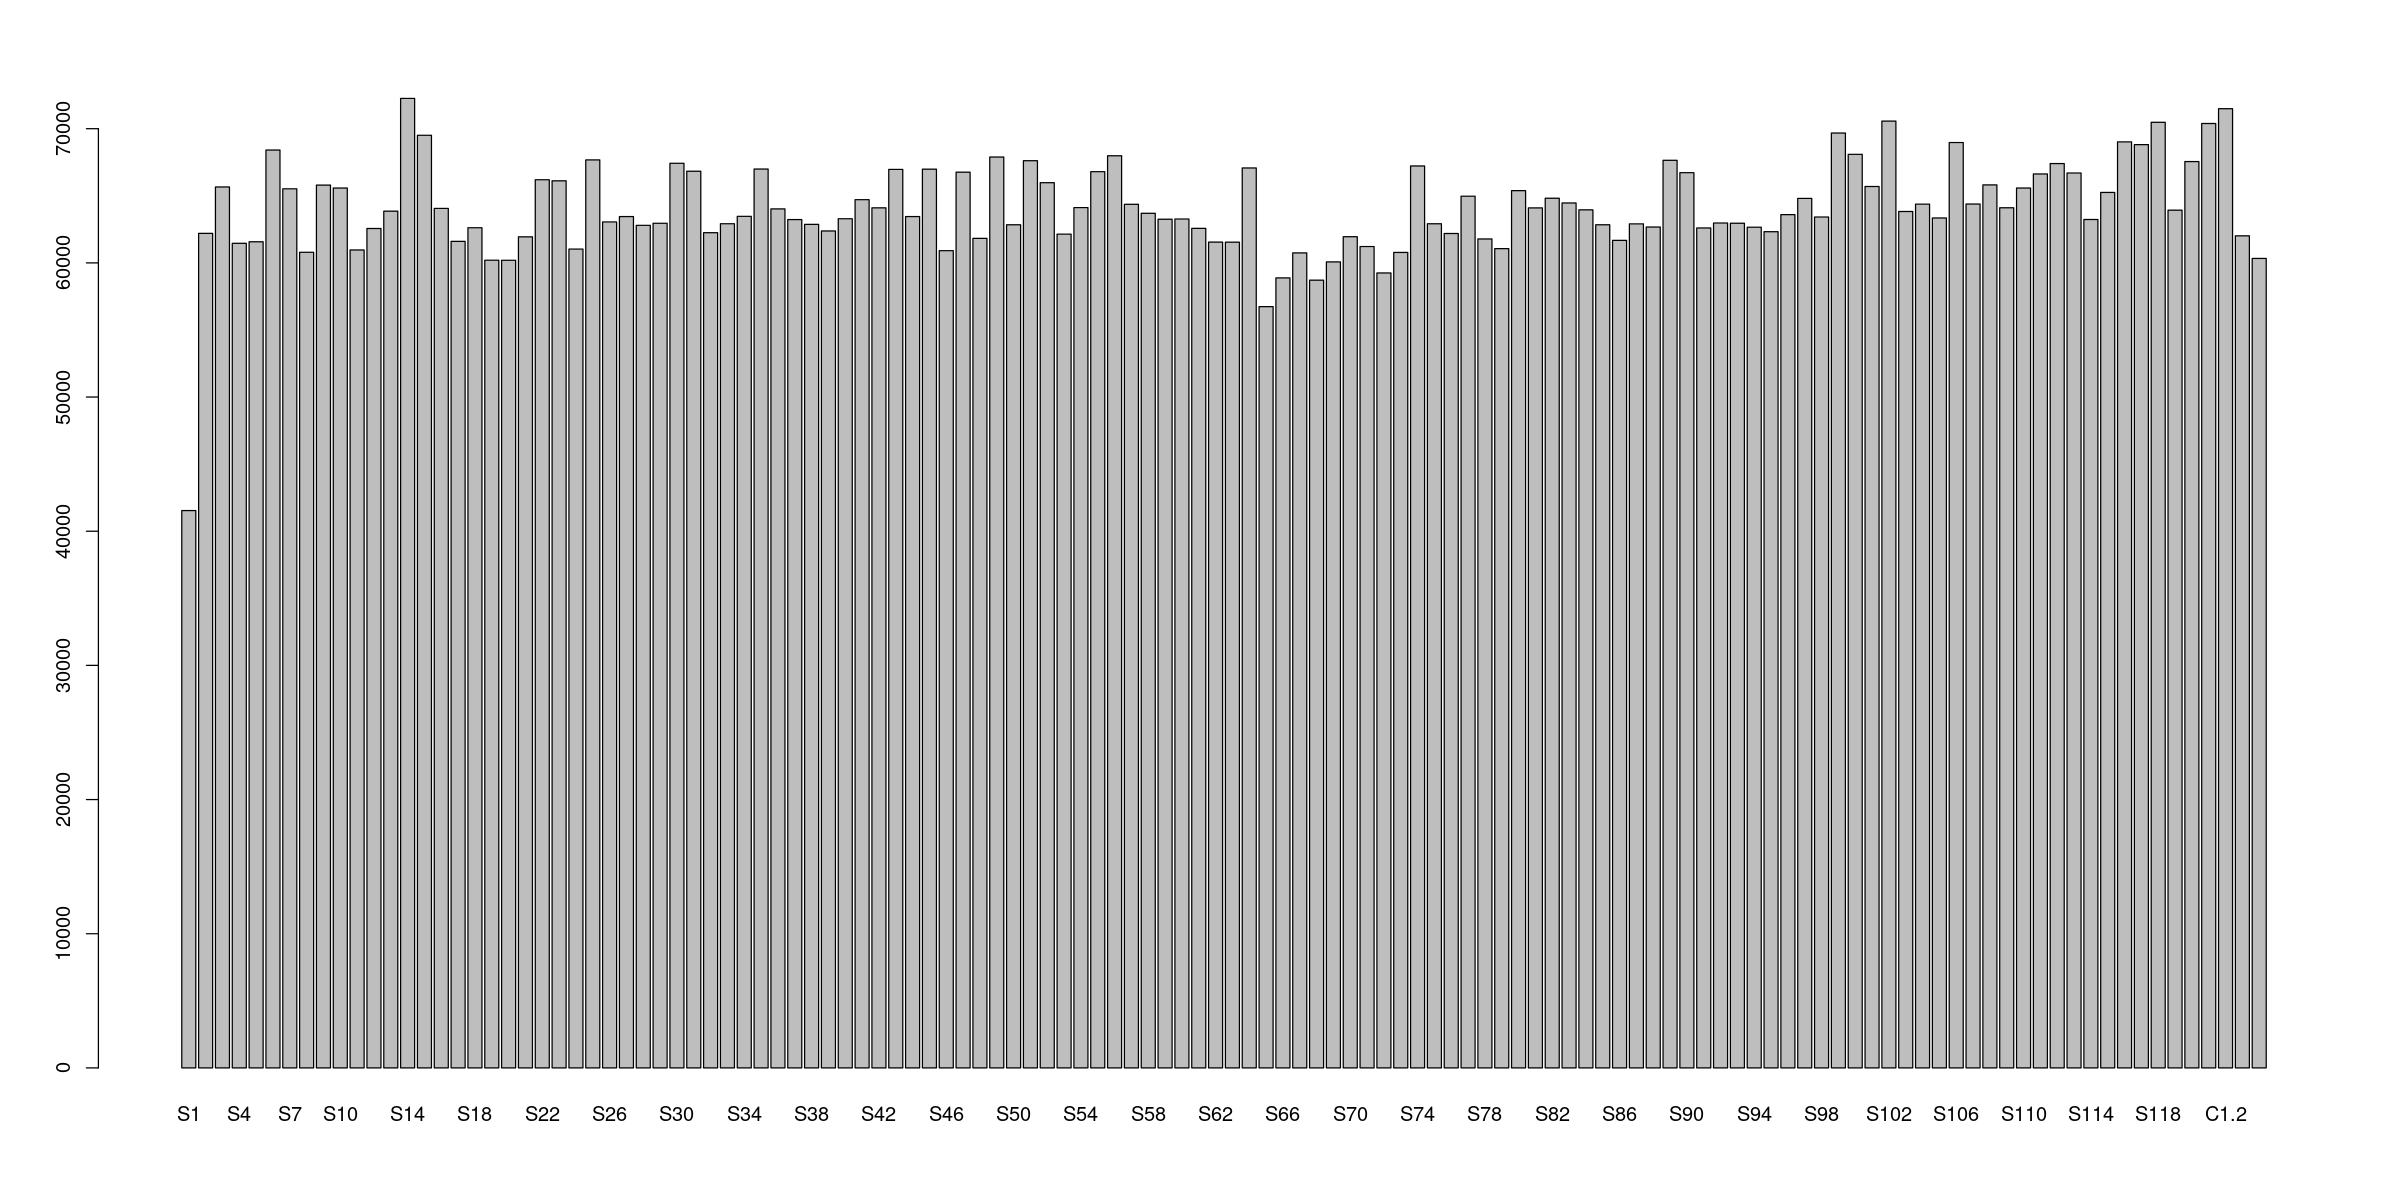

In [60]:
barplot(sample_sums(ps))

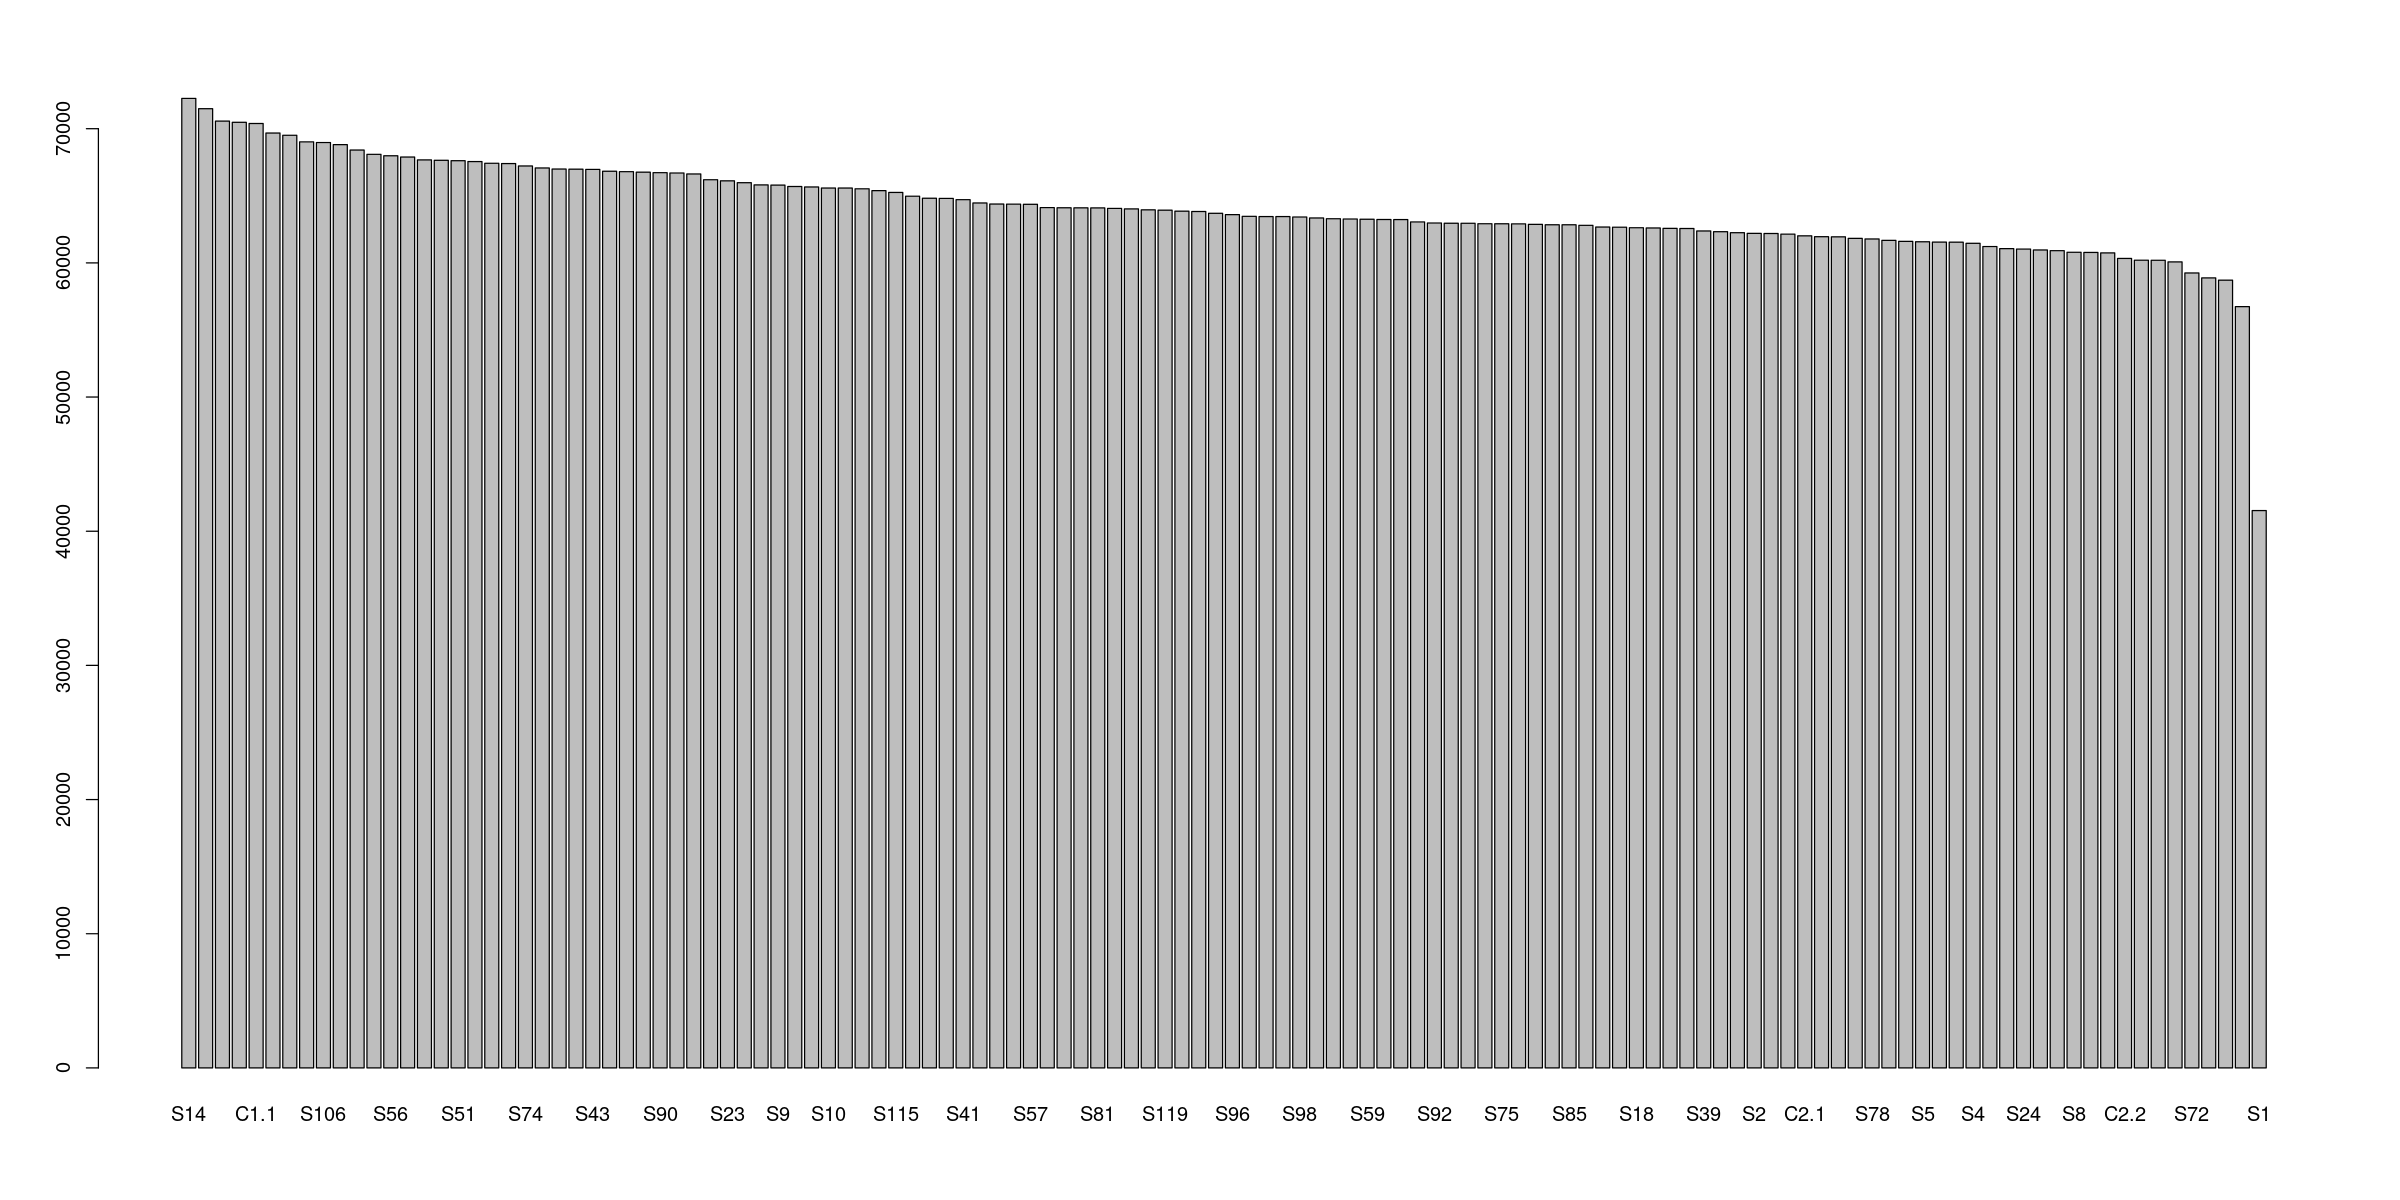

In [58]:
barpblot(sort(sample_sums(ps), decreasing=TRUE))

All-in-all, depths are pretty even. Hopefully, this means we don't have to account for variation in depths very much in our models. We'll check.

Let's take a look at the various controls that we did, to check possible biases in our lab and bioinformatic pipelines. Do this mostly in R, because phyloseq. We'll use the following plot function a lot:

In [24]:
rankAb <- function(phyObj, sampleName, ylimit=500, ntax=NULL, textatX=100, textatY=(ylimit-40)){
    sampleNo0filter <- get_taxa(phyObj, sampleName) > 0
    if(is.null(ntax)) ntax=sum(sampleNo0filter)
    print(sum(sampleNo0filter)) ## let user know how many unique taxa are in sample
    sampleNo0 <- get_taxa(phyObj, sampleName)[sampleNo0filter]
    sampleNo0 <- sort(sampleNo0, decreasing=TRUE)
    sampleNo0 <- sampleNo0[1:ntax]
    taxaNames=tax_table(phyObj)[ names(sampleNo0), "Genus"]
    nuASV <- paste("number of unique ASVs = ",sum(sampleNo0filter), sep="")
    par(cex.axis = .75, mar=c(25,4,4,2))
    barplot(sampleNo0,
        ylim = c(0,ylimit),
        main=sampleName,
        cex.names=1.5,
        las=2,
        names.arg=taxaNames,
           )
    text(textatX, textatY,  nuASV, cex = 2, )
}


<a id="SSC"></a><br>
### Single species control

The first set of controls consisted of pure water plus a high amount of DNA single species control, E. coli. 

[1] 216
[1] 144


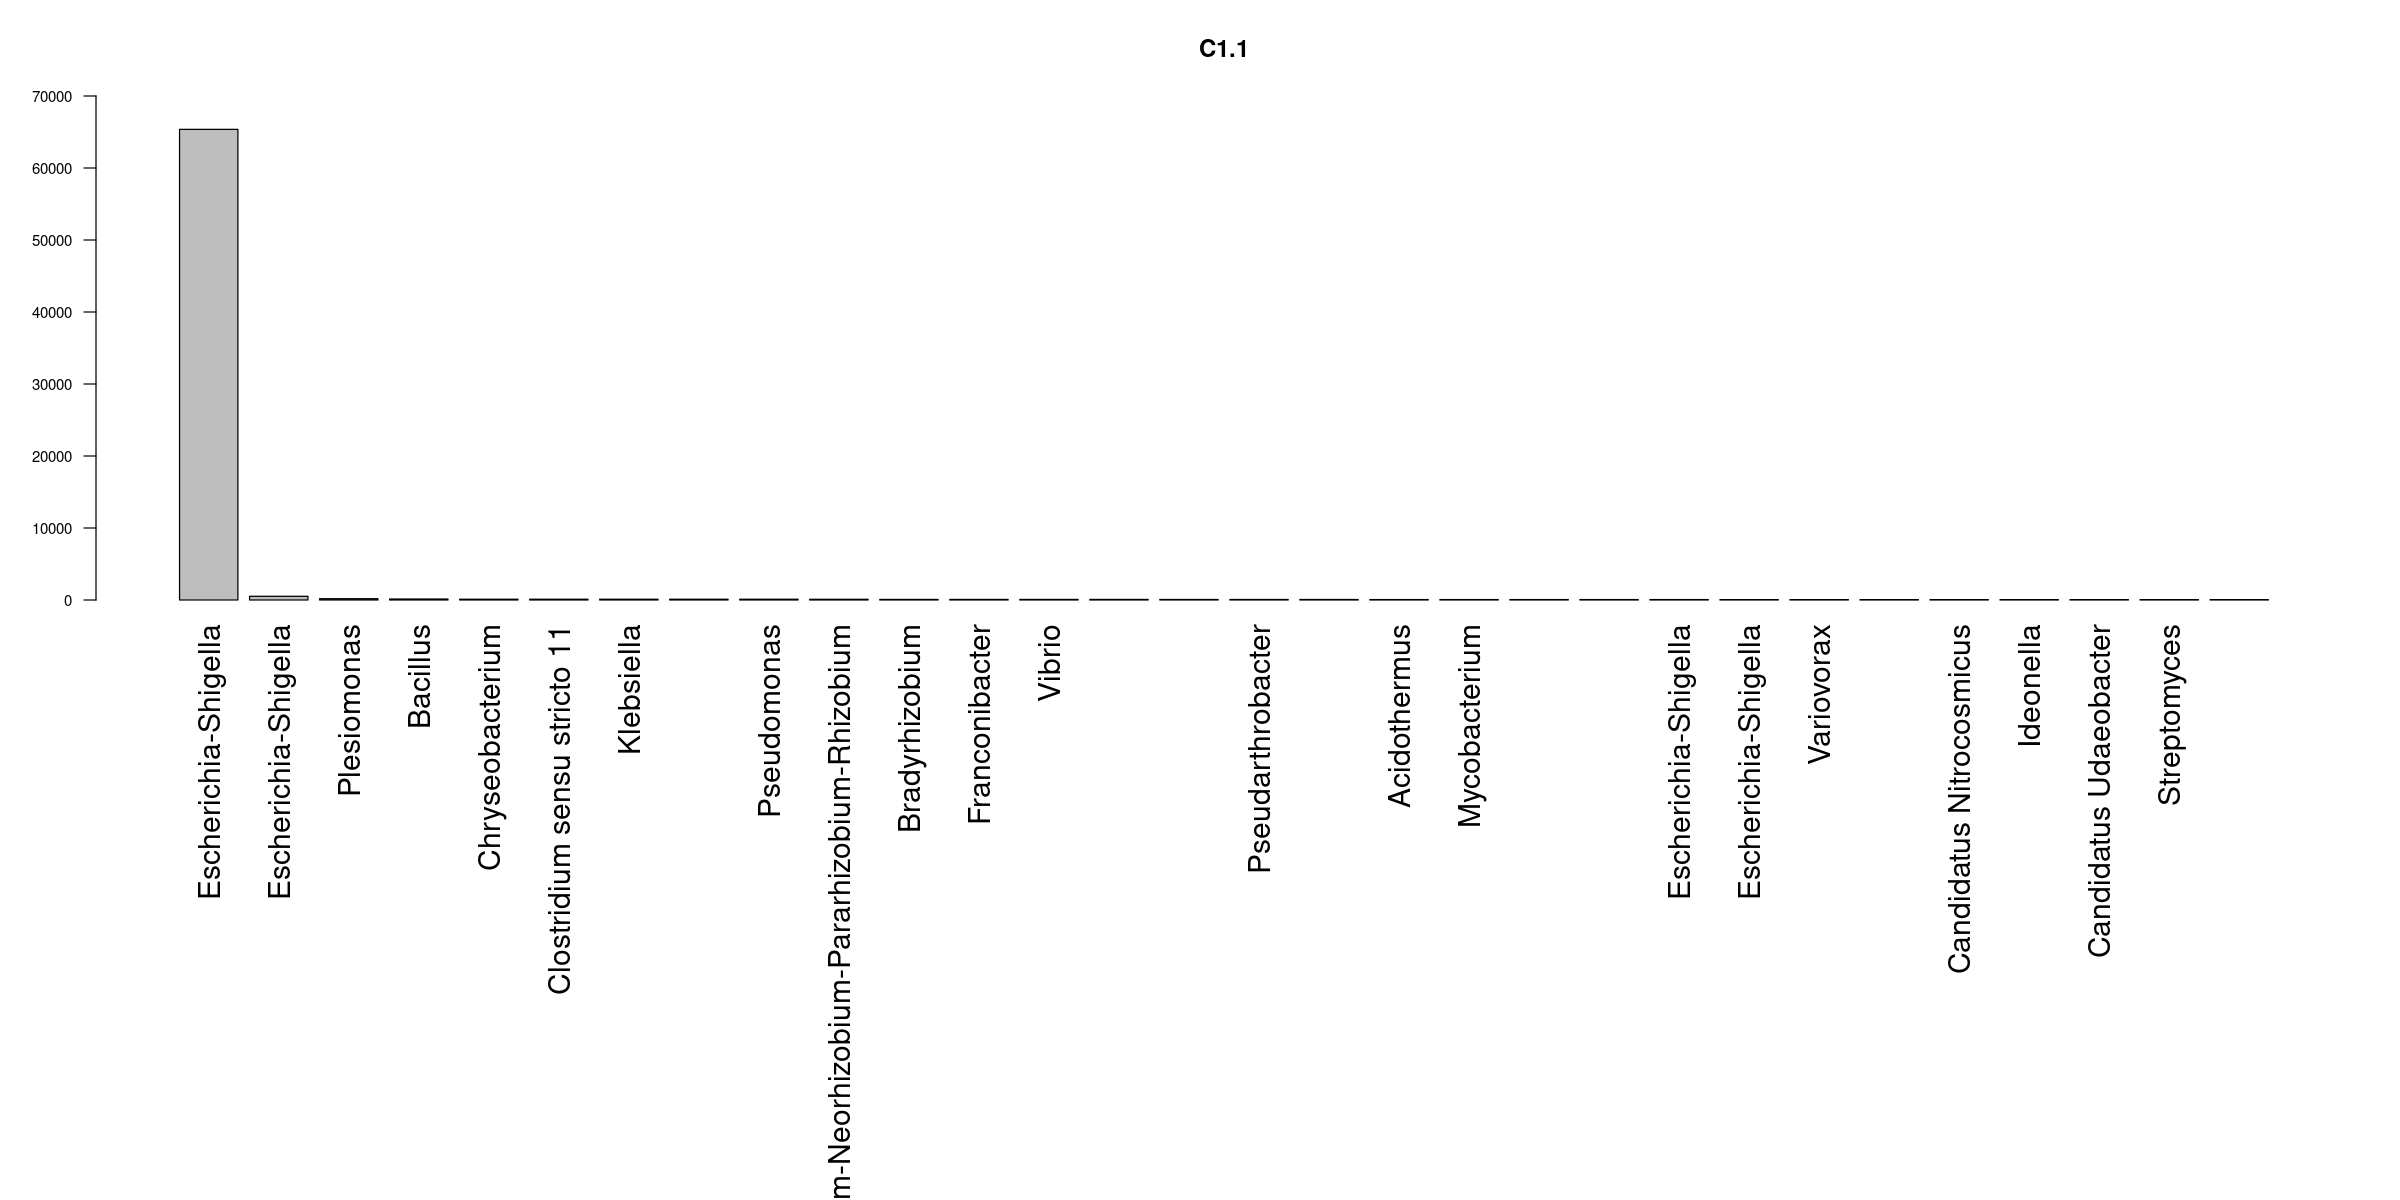

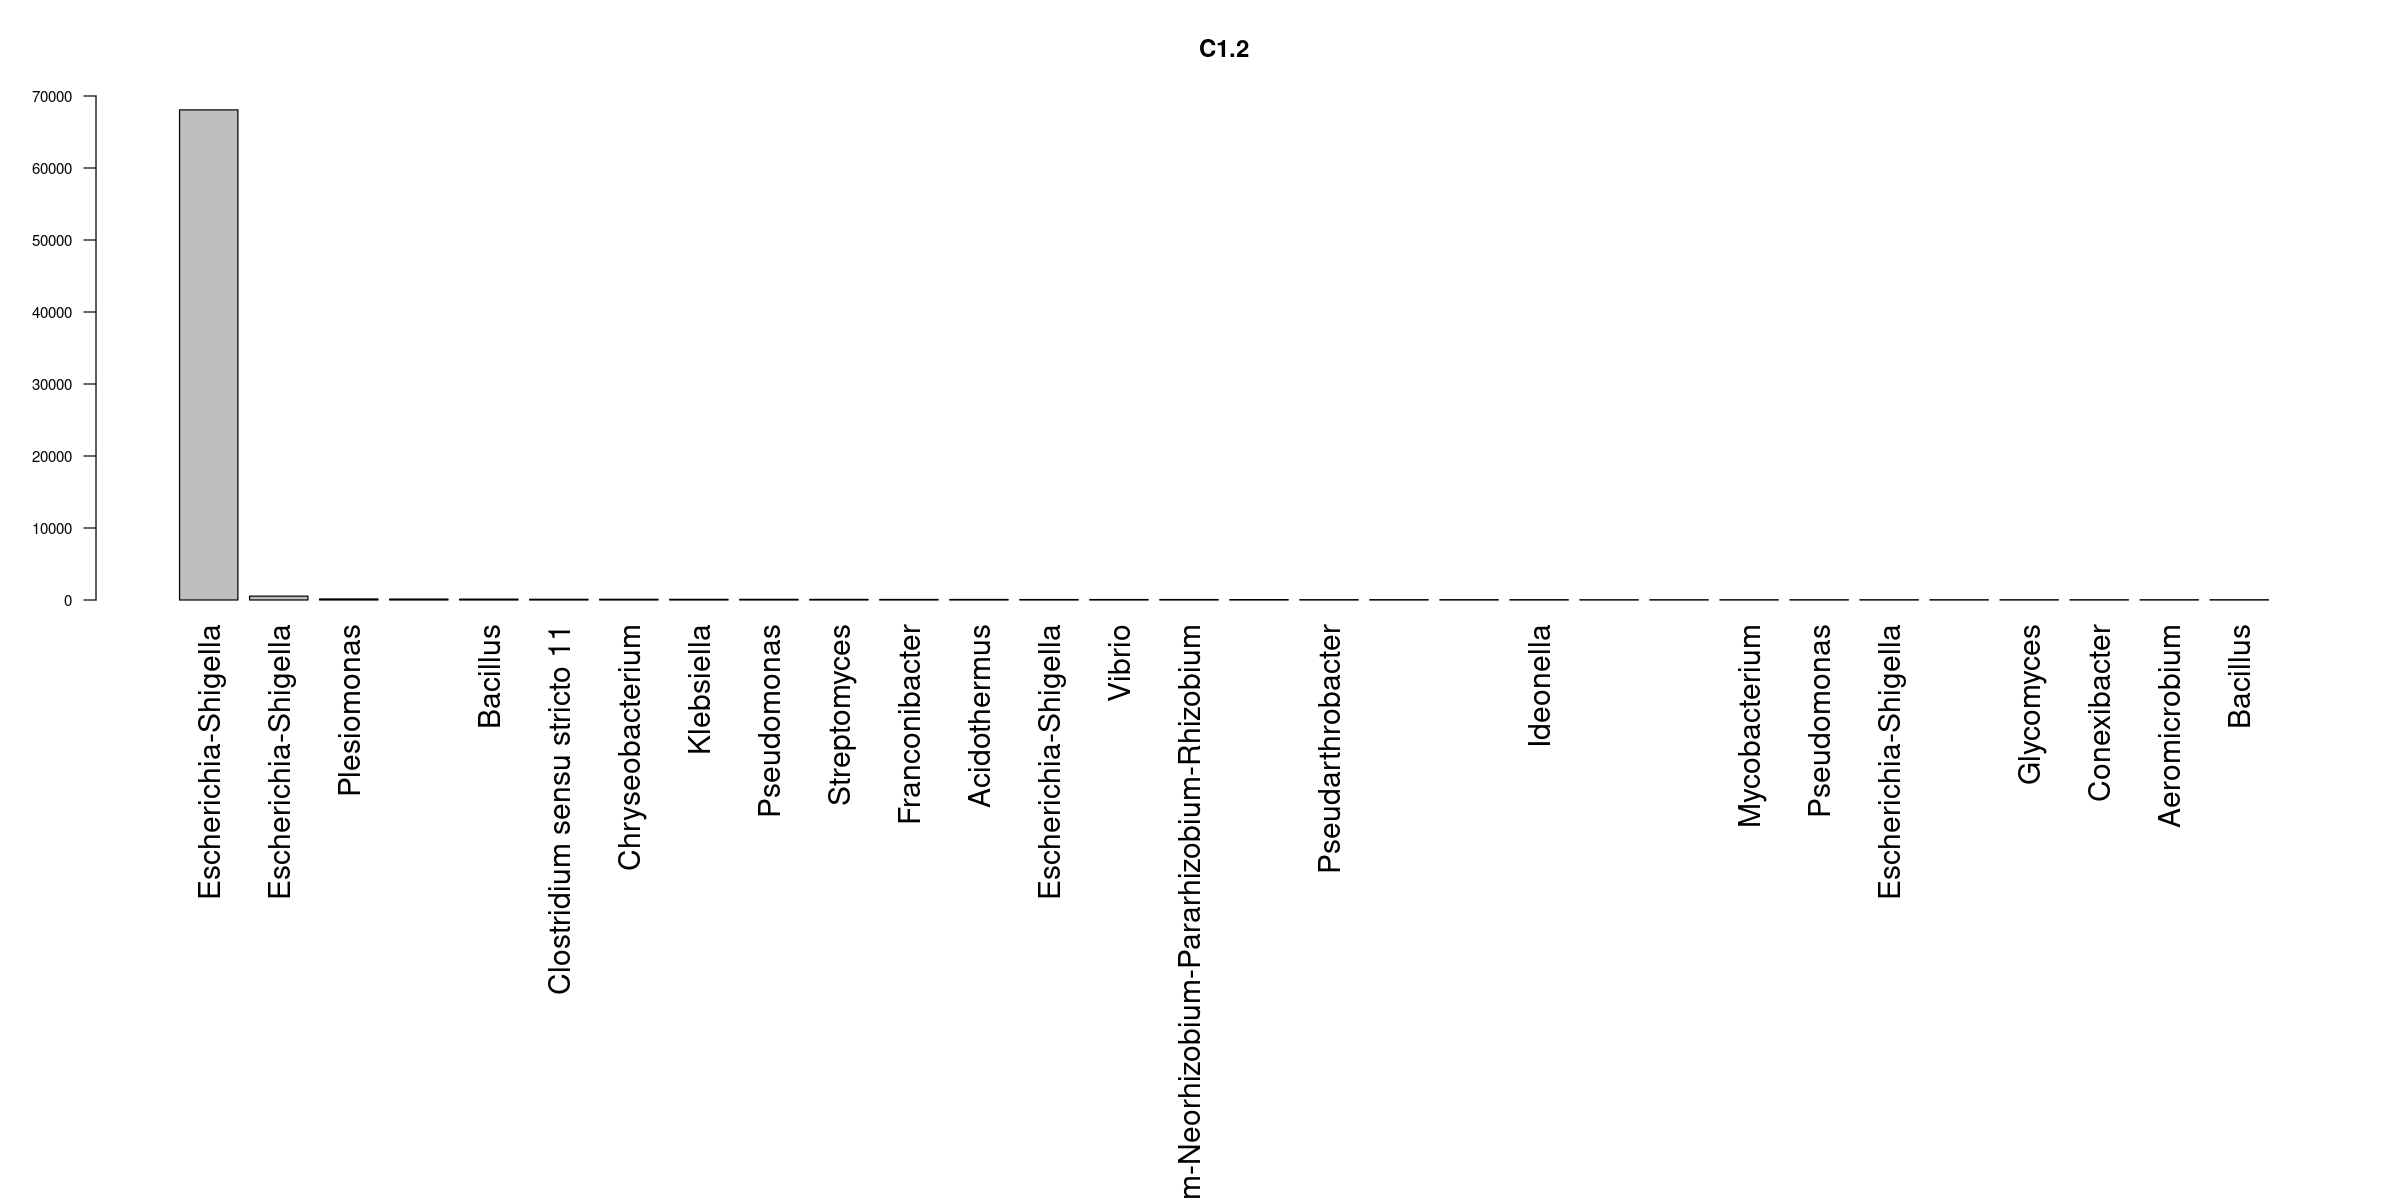

In [55]:
options(repr.plot.width=20, repr.plot.height=10)
rankAb(ps,"C1.1",ylimit=70000, ntax = 30)
rankAb(ps,"C1.2",ylimit=70000, ntax = 30)

These controls are dominated by E. coli, as expected. Because it is the most abundant organism in the study, E. coli is ASV1. We see some splitting of this ASV into one or two less abundant ASVs (Plesiomonas may also be a mis-identified a split off from this ASV). The contaminants are interesting, zooming in a little:

[1] 216
[1] 144


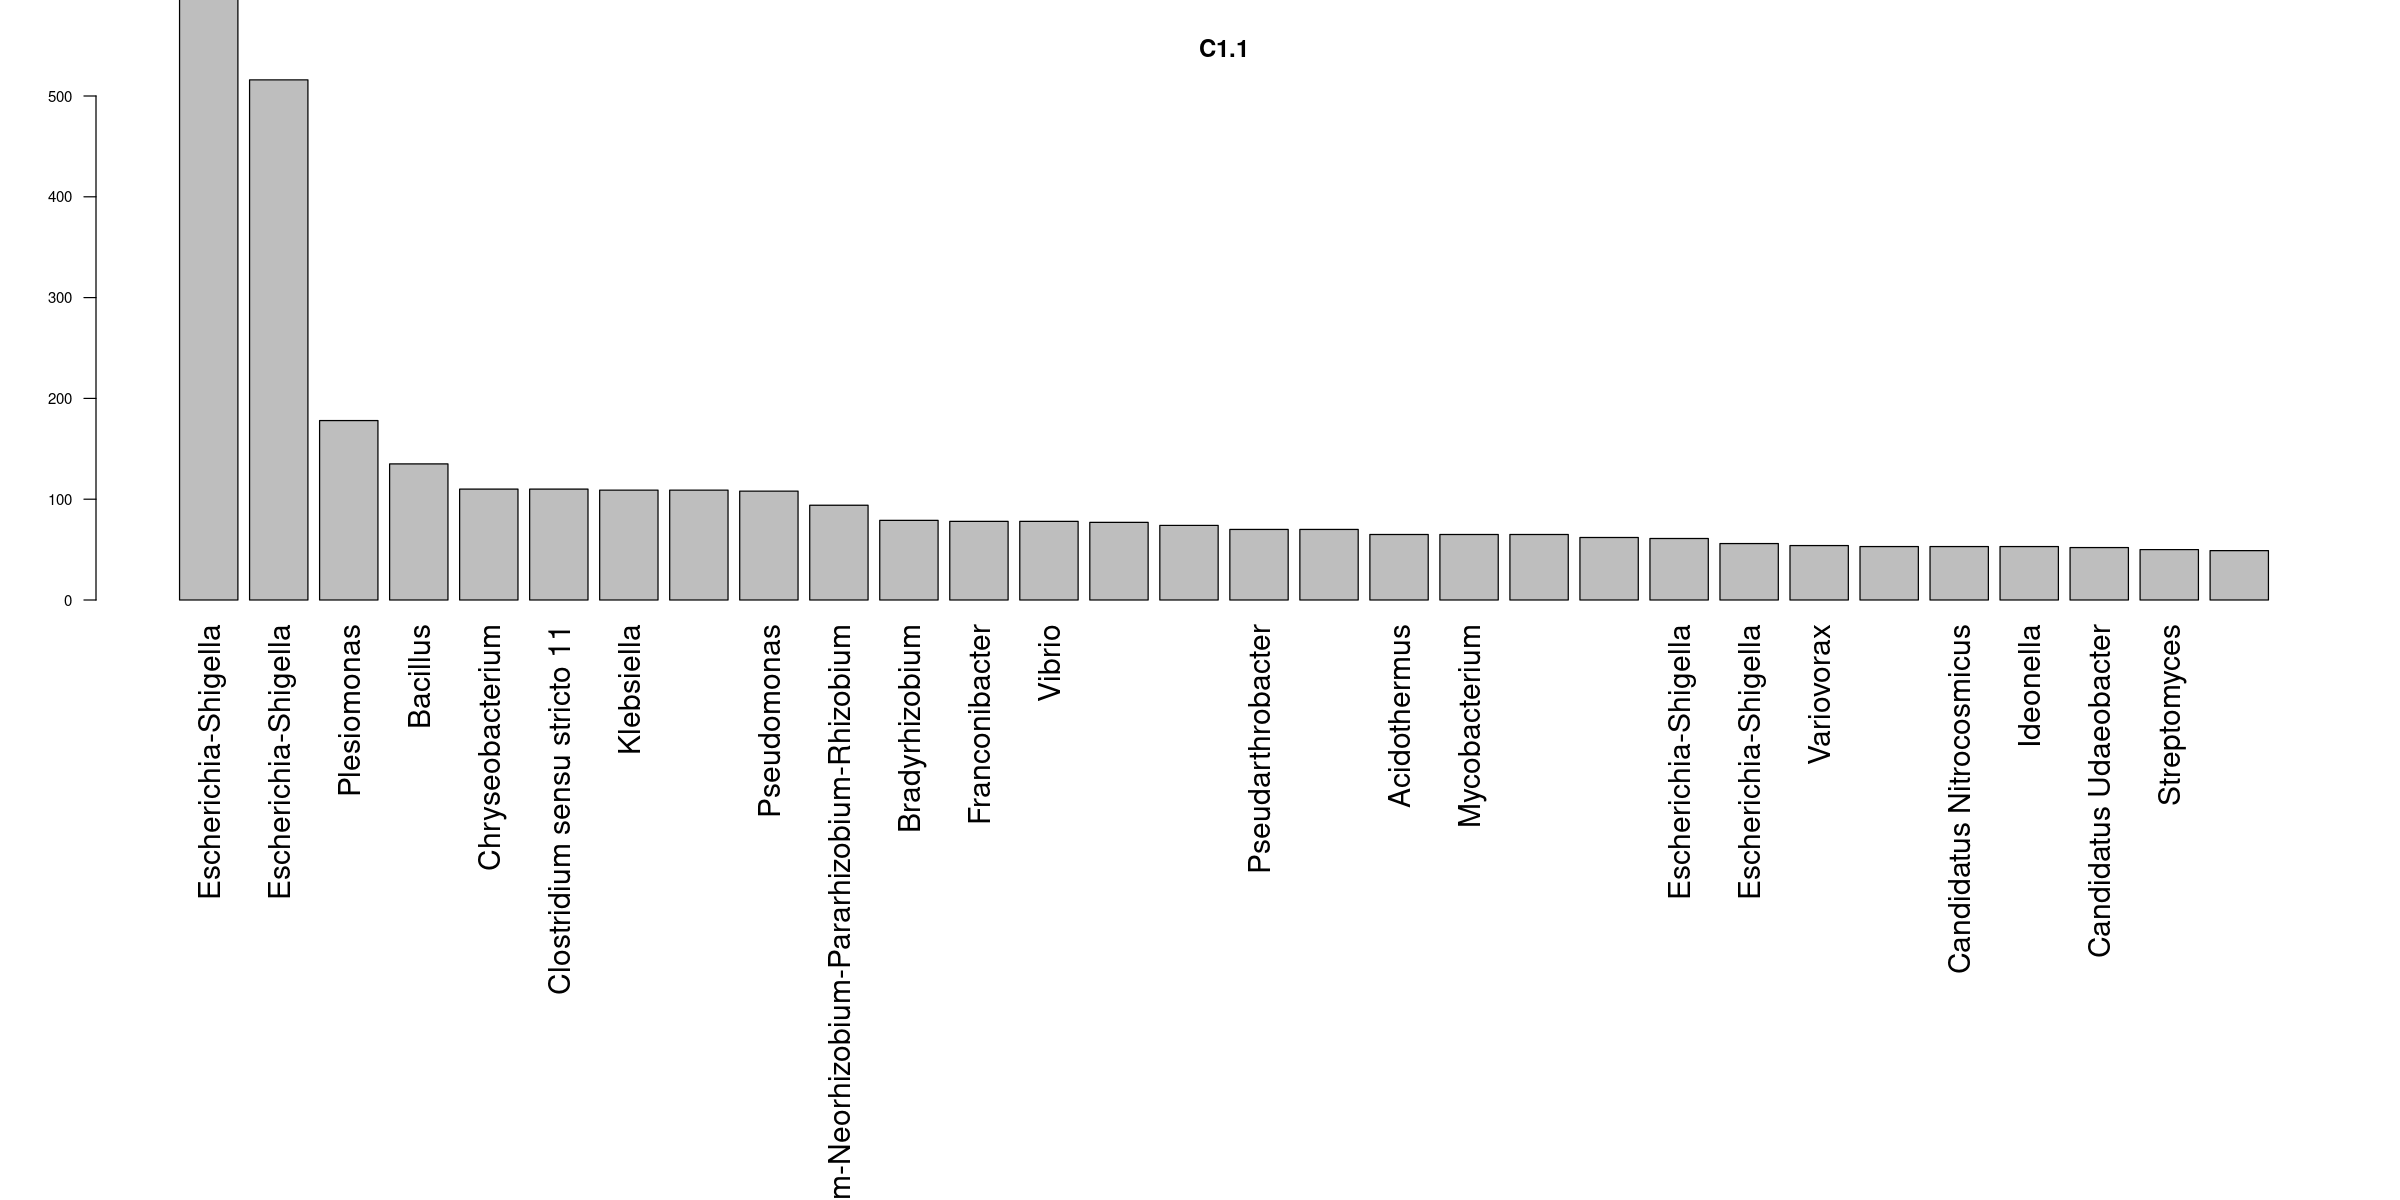

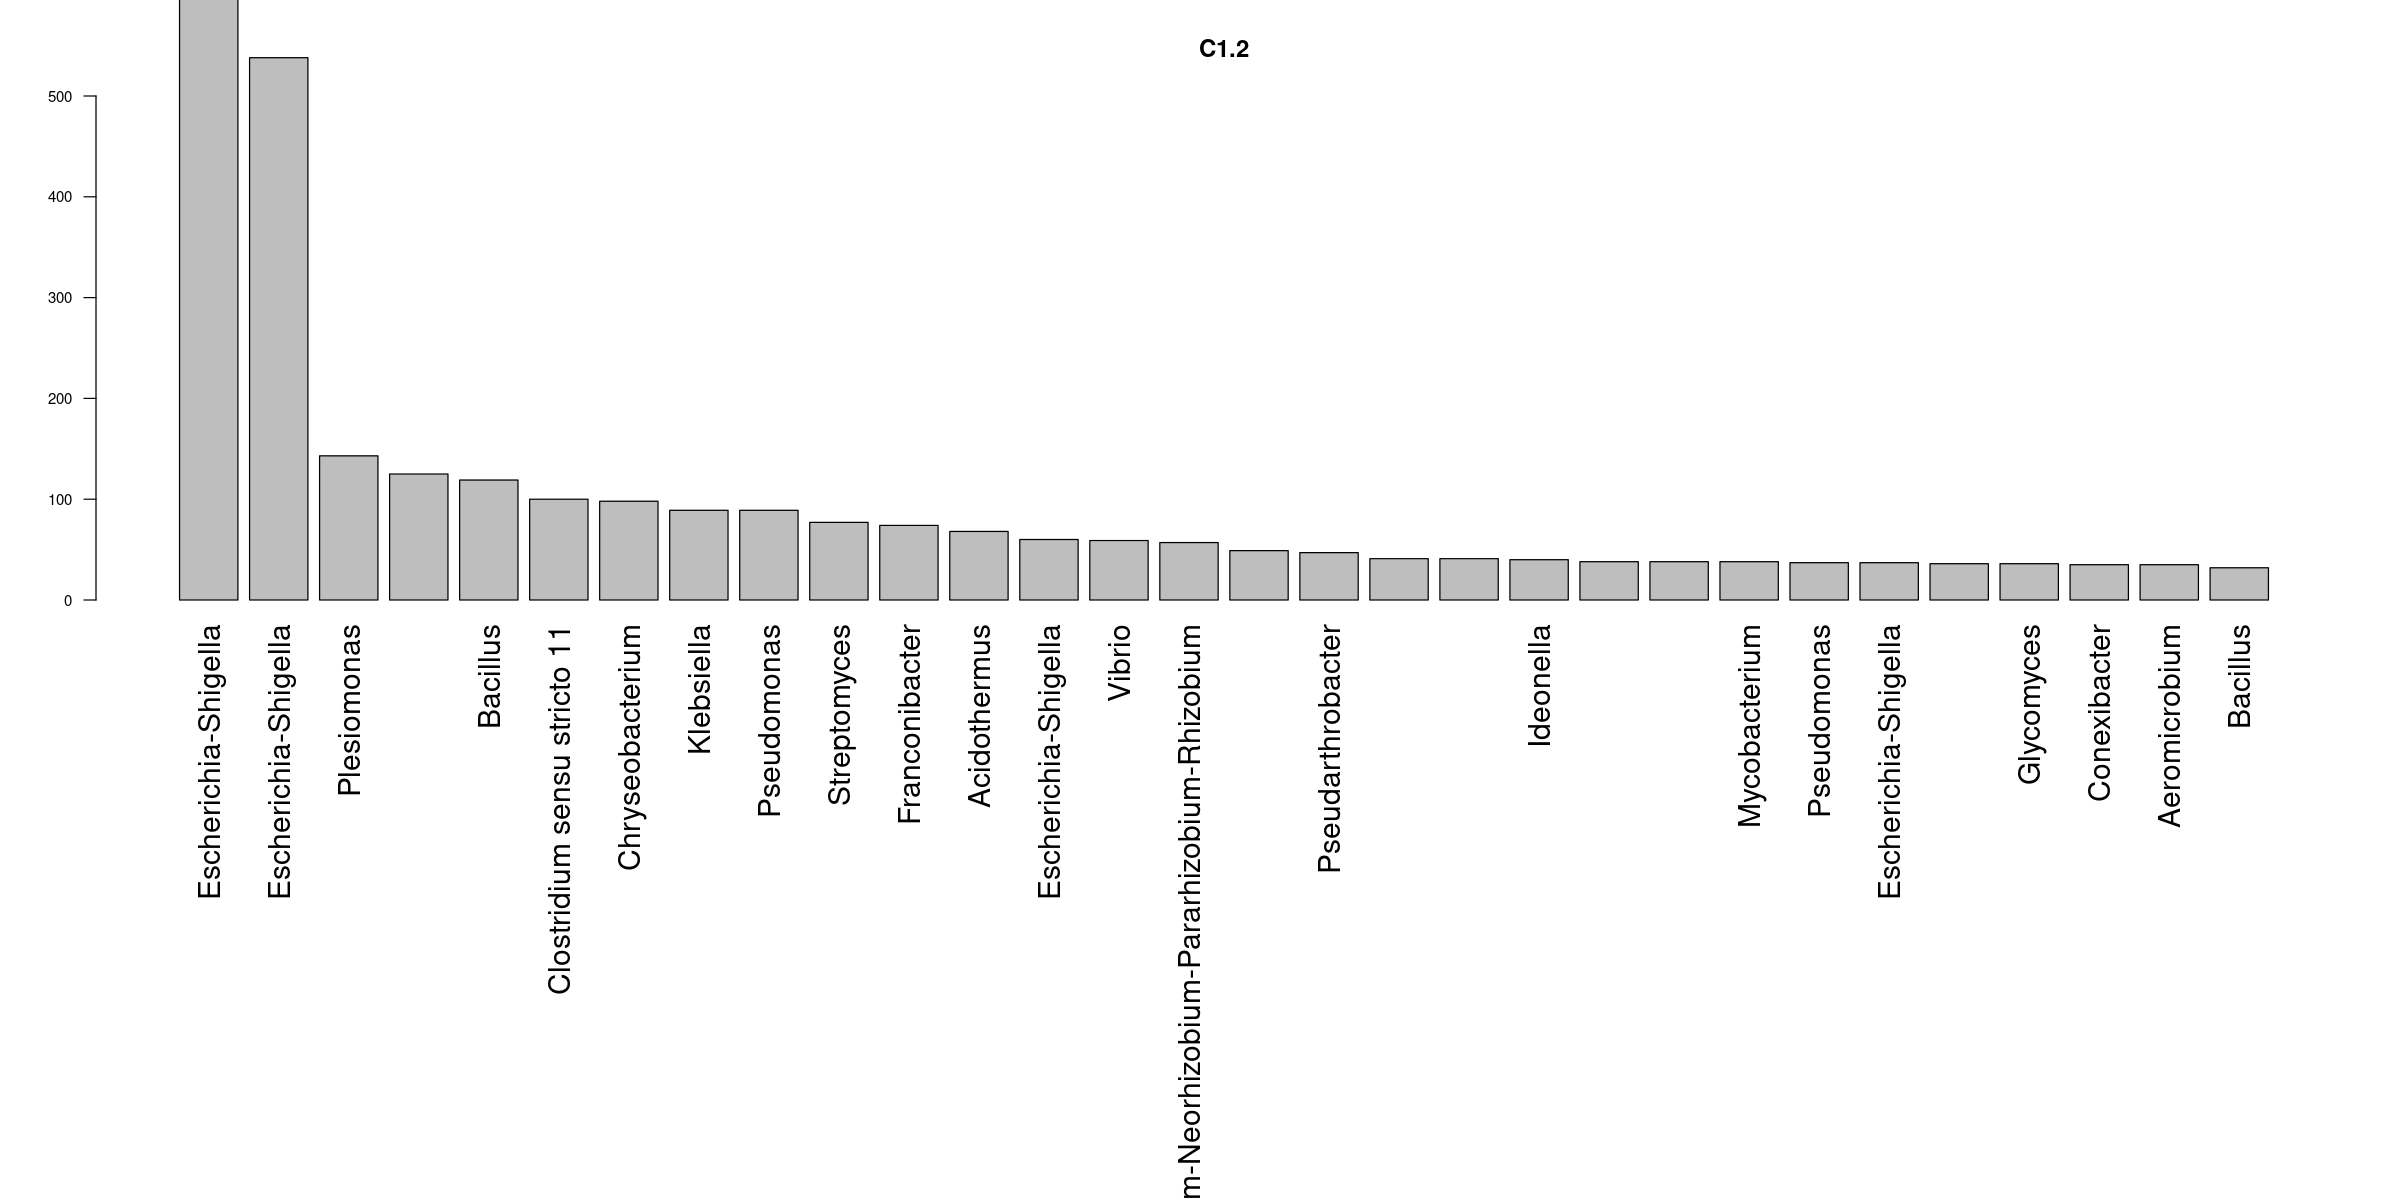

In [56]:
options(repr.plot.width=20, repr.plot.height=10)
rankAb(ps,"C1.1",ylimit=500, ntax = 30)
rankAb(ps,"C1.2",ylimit=500, ntax = 30)

Several of our mock-community members appear to have leaked over here, either through lab contamination or index-bleed on the sequencer. 

<a id="MCC"><br>
### Mock community controls

We included two samples containing the same mock community with ~equimolar solutions of DNA from 11 species of bacteria, plus the *E. coli* ASVs from the single species positive control.

| DSMZ name | (Sub)Phylum | Classified as | ASV# |
|  :--- | :---: | :---: | ---: |
|  Bacillus subtilis          | Bacillota            | Bacillus                                           | ASV29  |
|  Chryseobacterium luteum    | Bacteroidota         | Chryseobacterium                                   | ASV39  |
|  Clostridium roseum         | Bacillota            | Clostridium sensu stricto 11                       | ASV43  |
|  Enterobacter mori          | Gammaproteobacteria  | Klebsiella                                         | ASV62  |
|  Franconibacter helveticus  | Gammaproteobacteria  | Franconibactor                                     | ASV86, ASV943  |
|  Glycomyces tenuis          | Actinomycetetota     | Glycomyces                                         | ASV200  |
|  Pseudomonas fluorescens    | Gammaproteobacteria  | Pseudomonas                                        | ASV70, ASV275  |
|  Pseudomonas putida         | Gammaproteobacteria  | Pseudomonas                                        | ASV70, ASV275  |
|  Rhizobium endophyticum     | Alphaproteobacteria  | Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium | ASV78  |
|  Streptomyces acidiscabies  | Actinomycetatota     | Streptomyces                                       | ASV244  |
|  Variovorax guangxiensis    | Betaproteobacteria   | Variovorax                                         | ASV365  |
|  E. coli                    | Gammaproteobacteria  | Escherichia-Shigella                               | ASV365, ASV1315 |


What do our mock communities look like?:

[1] 94
[1] 103


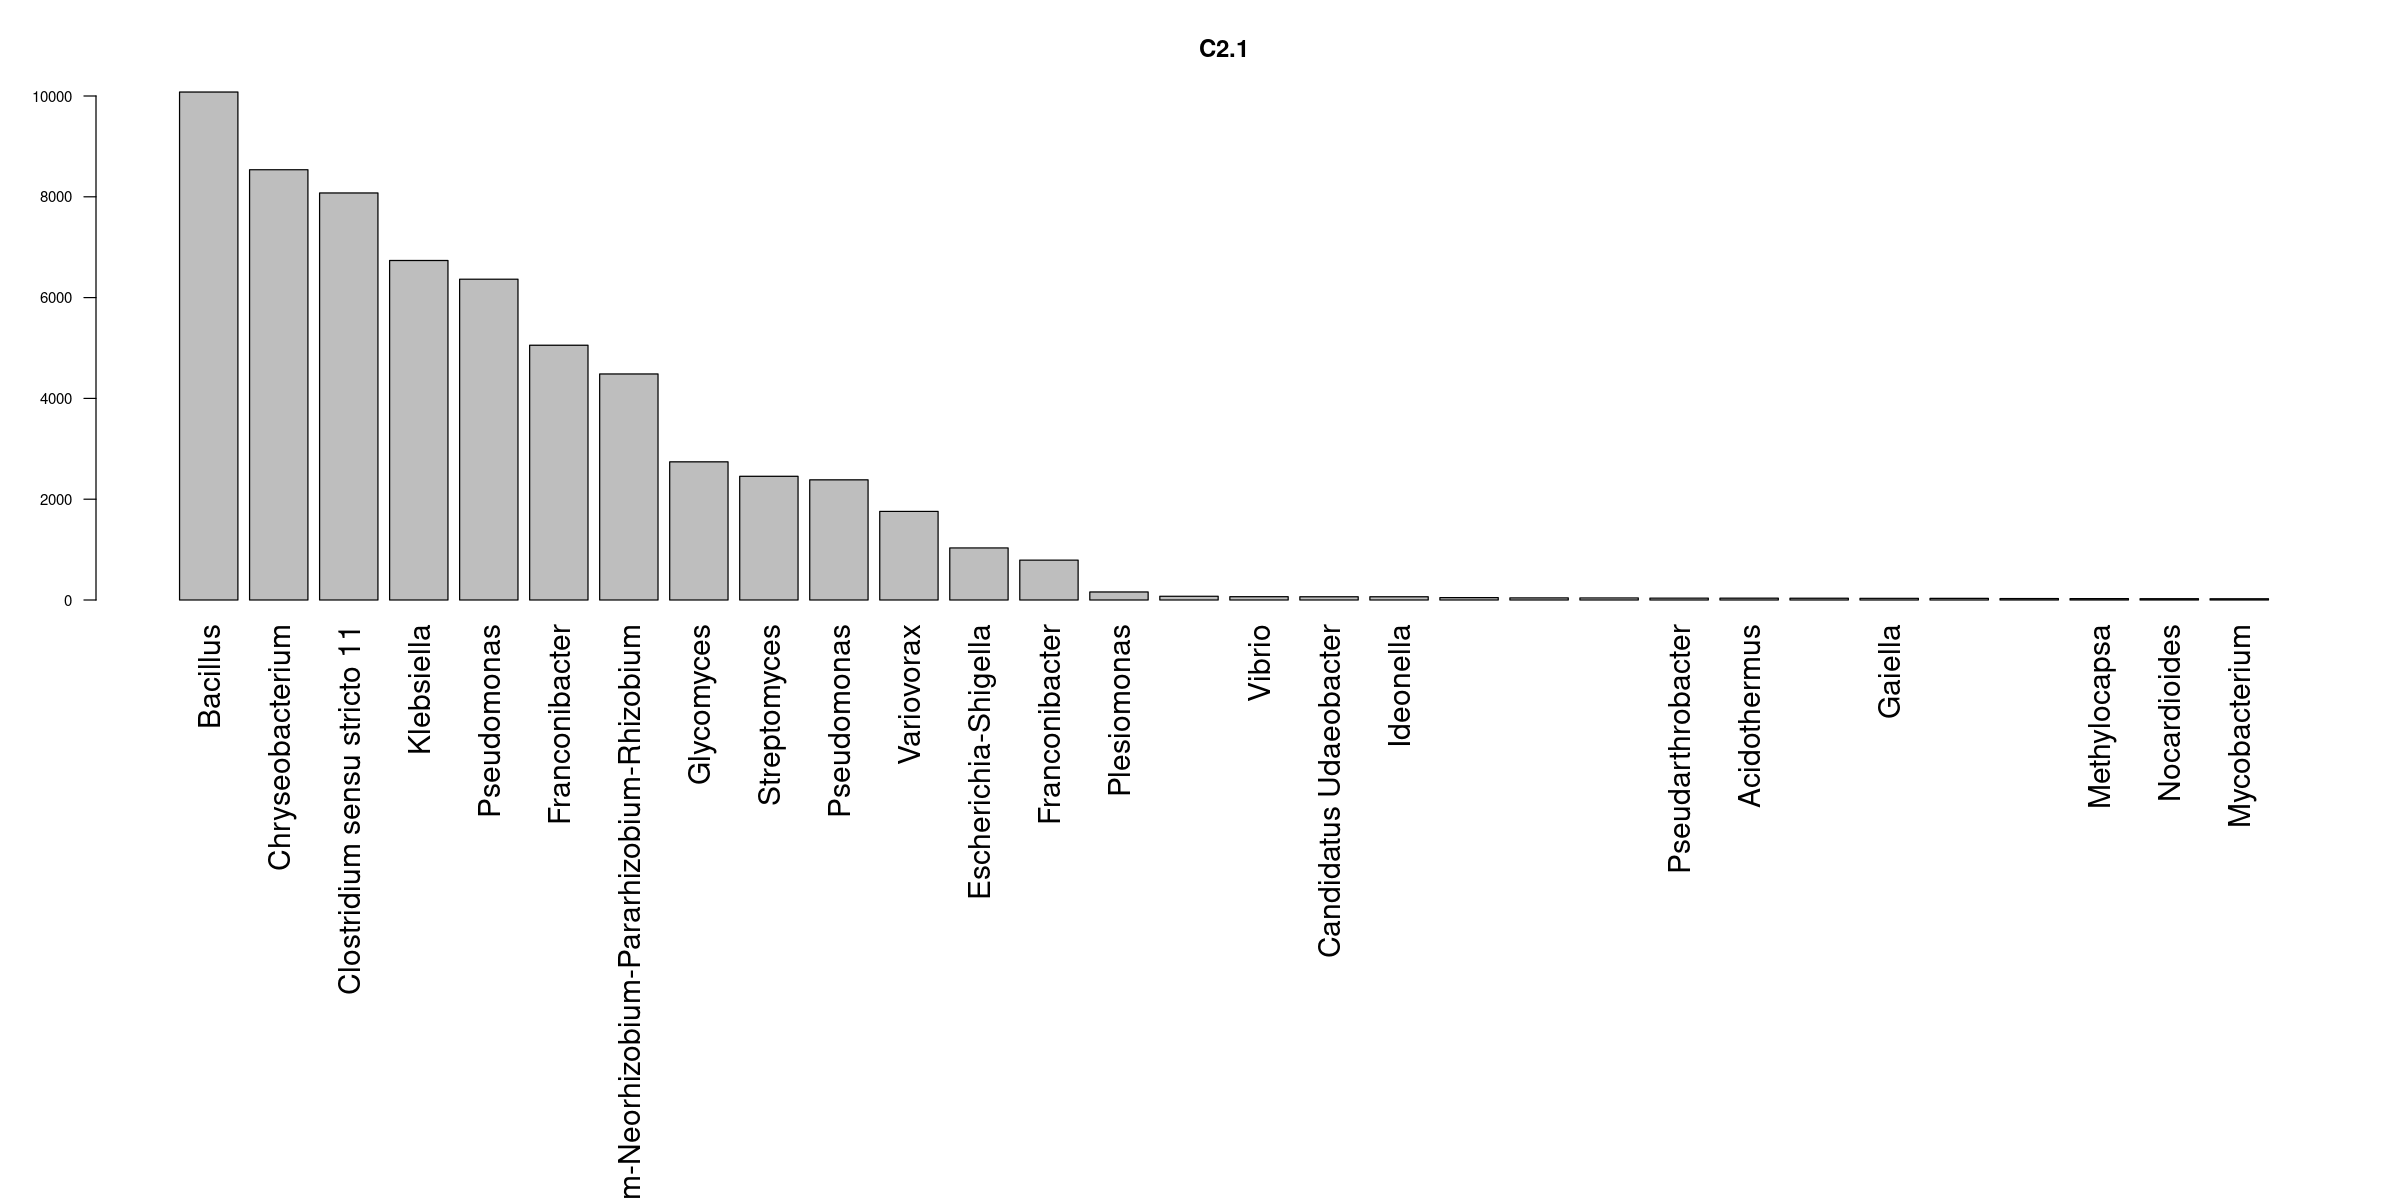

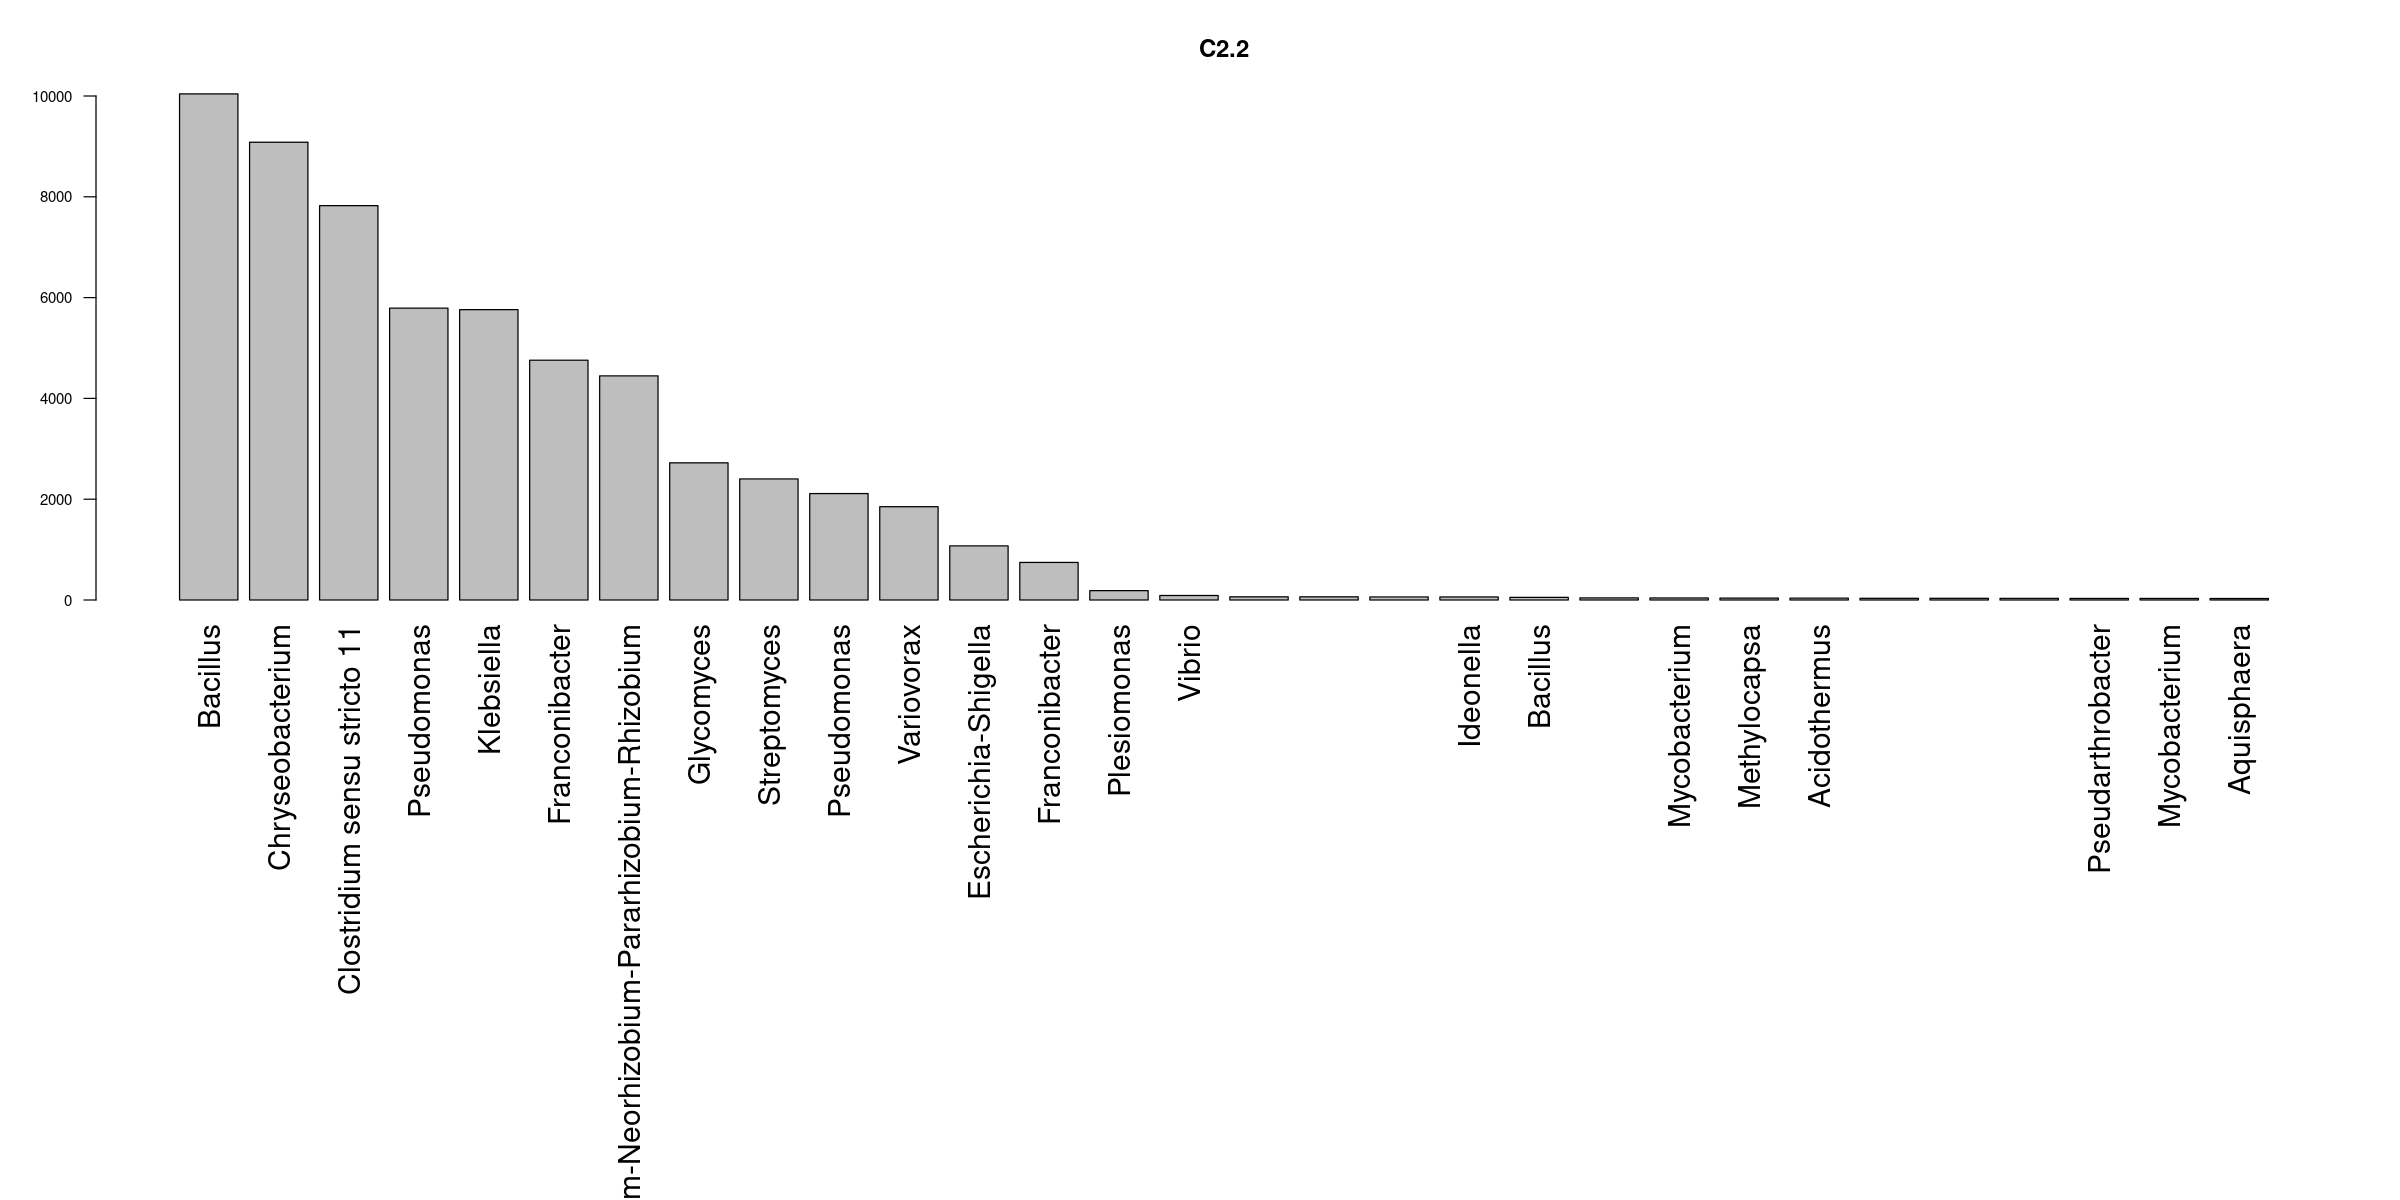

In [63]:
rankAb(ps,"C2.1",ylimit=10000, ntax = 30)
rankAb(ps,"C2.2",ylimit=10000, ntax = 30)

These show that we recovered most of our mock community members, but at very uneven ratios. Could be due to 16s copy number, PCR biases, or just the stochastic nature of Illumina sequencing. To reduce these artificial differences in abundances, we will transform our species matrix by converting to relative abundances (= divide the read numbers of each ASV in a sample by total number of reads in the sample), and then took the natural log of these abundances to diminish the importance of very abundant ASVs. This was done to create the community matrices loaded from .csv files above for general use by vegan, etc. We will do this transformation from raw reads again while building our big model below. 

Interestingly, there is considerable cross-contamination of abundant mock community members and E. coli from the single species control, with some patterns:

In [70]:
c2.1ASVs <- c("ASV29","ASV39","ASV43","ASV62","ASV70","ASV86","ASV78","ASV200","ASV244","ASV275","ASV365","ASV943")

options(repr.matrix.max.rows=600, repr.matrix.max.cols=200)
otu_table(ps)[,c2.1ASVs]


ASV29 ASV39 ASV43 ASV62 ASV70 ASV86 ASV78 ASV200 ASV244 ASV275 ASV365
S1       0    0     0     0     0     0    29     0      0      0      0  
S2       0    0     0     0     0     0    11     0      0      0      0  
S3       0    0     0     0     0     0     0     0      0      0      0  
S4       0    0     0     0     0     0    40     0      0      0      0  
S5      58   29    34    33    32    38    54    15      0      7      0  
S6      90   64    61    58    46    62    77    39      0     24     29  
S7      12    0     5    16     0     0    13     3      0      0      0  
S8       0    0     0     0     0     0    25     0      0      0      0  
S9       0    0     0     0     0     0     0     0      0      0      0  
S10      0    0     0     0     0     0     0     0      0      0      0  
S11      0    0     0     0     0     0    14     0      0      0      0  
S12      0    0     0     0     0     0    35     0      0      0      0  
S13     40   34    25    44    21    31    30     0      0      0      0  
S14     98   60    54    55    59    70    67    41      0      0     21  
S15     29    0     0     0     0     0    23     0      0      0      0  
S16      0    0     0     0     0     0     0     0      0      0      0  
S17      0    0     0    14     0     0    33     0      0      0      0  
S18      0    0     0     0     0     0    16     0      0      0      0  
S19      0    0     0     0     0     0    14     0      0      0      0  
S20      0    0     0     0     0     0    38     0      0      0      0  
S21     40   28    36    28    26    42    45    14      0      0      0  
S22     33   20    27    39    22     0    24    13      0      0      0  
S23      0    0     0     0     0     0     6     0      0      0      0  
S24      0    0     0     0     0     0    35     0      0      0      0  
S25      0    0     0     0     0     0     0     0      0      0      0  
S26      0    0     0     0     0     0    39     0      0      0      0  
S27      0    0     0     0     0     0    32     0      0      0      0  
S28     40   16    21    32     0    30    91    12      0      0      0  
S29     25   12    11    18     0    21    44     0      0     12      0  
S30      0    0     0     0     0     0     0     0      0      0      0  
S31      0    0     0     0     0     0     0     0      0      0      0  
S32      0    0     0     0     0     0    55     0      0      0      0  
S33      0    0     0     0     0     0    28     0      0      0      0  
S34      0    0     0     0     0     0    23     0      0      0      0  
S35      0    0     0     0     0     0     0     0      0      0      0  
S36     38   26    38    45    31    46    43    20      0      9      0  
S37     51   32    30    39    40    42    36    13      0      0      0  
S38      0    0     5     0     0     0    19     0      0      0      0  
S39      0    0     0     0     0     0    49     0      0      0      0  
S40      0    0     0     0     0     0    16     0      0      0      0  
S41      0    0     0     0     0     0     0     0      0      0      0  
S42      0    0     0     0     0     0    25     0      0      0      0  
S43      0    0     0     0     0     0     0     0      0      0      0  
S44     31   25    24    43    29    24    56    10      0     18      0  
S45     19   14    28    15    21    51    18     0      0      0      0  
S46      0    0     0    21     0     0    51     2      0      0      0  
S47      0    0     0     0     0     0     0     0      0      0      0  
S48      0    0     0     0     0     0    70     0      0      0      0  
S49      0    0     0    13     0     0     0     0      0      0      0  
S50      0    0     0     0     0     0    28     0      0      0      0  
S51      0    0     0     0     0     0     0     0      0      0      0  
S52     40   28    34    35    37    30    16    12      0      0      0  
S53     45   27    28    37   

The more "abundant" ASVs from our positive controls are occurring other samples. They seem to occur together, in a particular set of samples (S5-6, S13-14, S21-22, S28-29, etc. etc.). Often they are cycling through in sets of eight, this is odd, points to some sort of pattern of lab contamination via an eight-channel pipette or contamination in the columns in the plate. This could have happened either in our lab or in the lab that prepped the DNA for illumina sequencing. However, Sulari did not work in plates or with a multichanner pipetter. We worked with individual samples in eppendorfs. This could also be some sort index bleed with the illumina sequencer, but I don't think that would show up on a sample-level like this. 

The most contaminated sample seems to be S120, it has almost all the of the mock community ASVs. OTU1 (E. coli) from our single species control is the most abundant cross contaminate, occurring in ~half of our samples:

In [72]:
otu_table(ps)[,"ASV1"]

ASV1 
S1      20
S2       0
S3     344
S4     376
S5       0
S6       0
S7       0
S8      32
S9       0
S10      0
S11    221
S12    256
S13      0
S14      0
S15      9
S16     24
S17      0
S18      0
S19    343
S20    446
S21      0
S22      0
S23      0
S24     19
S25      0
S26    174
S27    245
S28      0
S29      0
S30      0
S31     11
S32      0
S33      0
S34    242
S35    251
S36      0
S37      0
S38      0
S39     18
S40      0
S41     30
S42    278
S43    326
S44     44
S45      0
S46      0
S47     45
S48     46
S49      0
S50    332
S51    290
S52      0
S53      0
S54     38
S55     69
S56     34
S57      0
S58    296
S59    344
S60     70
S61      0
S62      0
S63     55
S64     39
S65    132
S66    345
S67    353
S68     49
S69      0
S70     49
S71     53
S72     67
S73      0
S74    229
S75    270
S76      0
S77      0
S78      0
S79     19
S80     14
S81      0
S82    217
S83    315
S84     34
S85      0
S86      0
S87     30
S88      0
S89      0
S90    250
S91    368
S92      0
S93      0
S94      0
S95     64
S96     31
S97      0
S98      8
S99      0
S100     0
S101     0
S102     0
S103     0
S104     0
S105     0
S106     0
S107     0
S108     0
S109     0
S110     0
S111     0
S112     0
S113     0
S114     0
S115     0
S116     0
S117     0
S118     0
S119     0
S120  1337
C1.1 65364
C1.2 68075
C2.1  1033
C2.2  1074

E. coli should not be this abundant in soils. We have to remove this OTU from further consideration. The other contaminants from the mock community are fairly low in abundance, which we can remove with abundance thresholds. This is comforting, because contamination seems to be a function of abundance, but it takes a very abundant organism to spill over to other samples.

<a id="otuClust"></a><br>
### Corrections for contamination and OTU clustering

#### Make a 16s Tree from ASV consensus sequences

Now we will try to reduce the consequences of these errors on our ecological interpretation, through some transformations of the data, and some manual modifications. Part of this process is clustering our OTUs to a reasonable level that reflects the biological reality of our system. In order to cluster our OTUs with a phylogenetically informative marker like 16s, we need a tree. Our phylogenetic tree is made using the representative sequences for all ASVs that exceeded 50 reads in at least one site, from dada2 outputs. This tree therefore contained phylogenetic information from 4370 ASVs (out of the original 36140 ASVs). We'll use [SSU-align](http://eddylab.org/software/ssu-align/) for the 16s alignments and [FastTree2](http://www.microbesonline.org/fasttree/) for the tree building algorithm. 

First step is figure out which ASVs we actually need to pay attention to, to reduce the computational load of alignments and tree building.

In [78]:
## transform sulari's original phyloseq object
## enforce a minimum of 50 reads
minCutoff <- 50
ot <- otu_table(ps)
ot[ot < minCutoff] <- 0
psMinCutoff <- ps
otu_table(psMinCutoff) <- ot
## normalize by abundances then log to flatten abundance differences
aa <- transform_sample_counts(psMinCutoff, function(x) x/sum(x))
## now log transform. Add 1 to avoid the log giving a non-zero 
## value to zero abundances
otu_table(aa) <- otu_table(aa) + 1
logMin50ps <- transform_sample_counts(aa, log)

## get rid of zero abundance ASVs
logMin50ps = prune_taxa( taxa_sums(logMin50ps) > 0, logMin50ps )

## export the sequences as a fasta file for the aligner:
#Biostrings::writeXStringSet(refseq(logMin50ps), "sulariAbundantASV16s.fna", append=FALSE,
#                                  compress=FALSE, compression_level=NA, format="fasta")


In [79]:
logMin50ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4370 taxa and 124 samples ]
sample_data() Sample Data:       [ 124 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 4370 taxa by 6 taxonomic ranks ]
refseq()      DNAStringSet:      [ 4370 reference sequences ]

Once we have this fasta of important rep sequences, pass it to the alignment and tree-building software. 

In [ ]:
## in BASH
## not run from this notebook, include code here for future reference:
ssu-align -n bacteria sulariAbundantASV16s.fna sulariAbundantASV16s_ali
## then a strict mask, don't trust any ambiguous calls, because we are forcing the bacterial model on archea
ssu-mask --pf 0.9999 --pt 0.9999 sulariAbundantASV16s_ali

## to get a fasta output of the alignment (what we probably need)
ssu-mask --stk2afa sulariAbundantASV16s_ali


In [ ]:
## also not run in notebook, for future reference
ssuAlignOut="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis/sulariAbundantASV16s_ali/sulariAbundantASV16s_ali.bacteria.afa"
FastTree -gtr -nt < $ssuAlignOut > sulariFastTree.nwk

It's a big tree, better viewed with ARB, but for this notebook we can get a quick look at this in R, to make sure there aren't parsing errors.

In [4]:
aa = ape::read.tree("sulariFastTree.nwk")

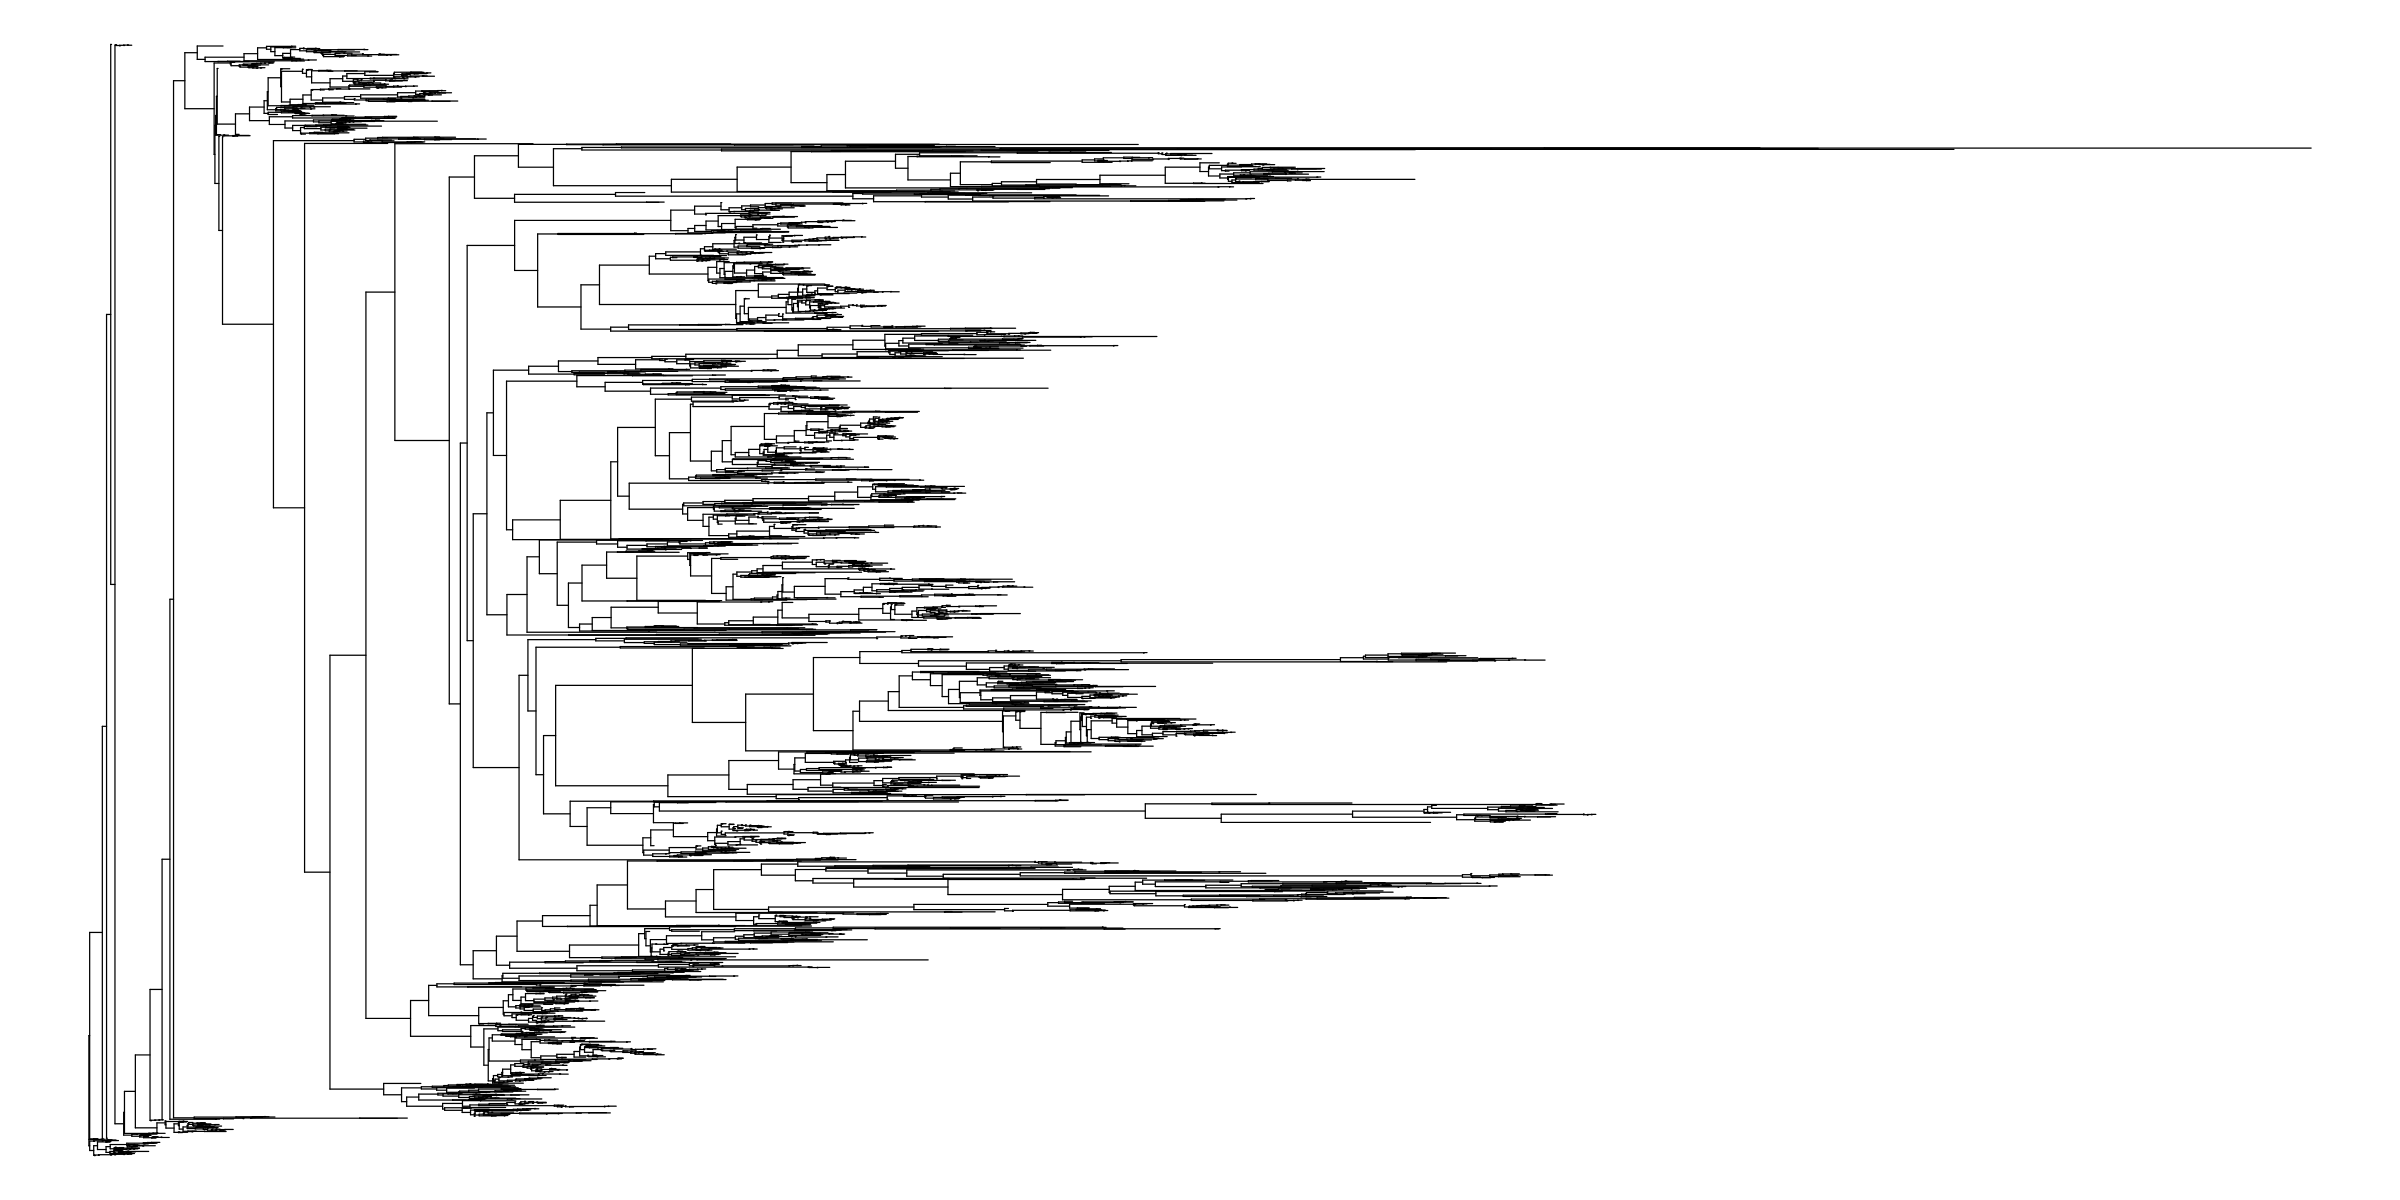

In [77]:
plot(aa, show.tip.label = FALSE, no.margin = TRUE)

Let's add this phylogenetic tree to our ps object, it will come in handy.

In [4]:
aa <- read_tree("sulariFastTree.nwk")
phy_tree(ps) <- aa

In [5]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 4300 taxa and 124 samples ]
sample_data() Sample Data:       [ 124 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 4300 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 4300 tips and 4298 internal nodes ]
refseq()      DNAStringSet:      [ 4300 reference sequences ]

We won't save this, because adding the tree immediately trims our phyloseq object down to just those ASVs represented on the tree. For data integrity, we'll just add this tree when we need it, after loading the original phyloseq object.

#### Cluster OTUs using 16S tree

Next we will try to find the level of similarity among sequences that recovers all of our mock community members but does not artifically split them. We'll use phyloseq and it's phylogenetic agglomeration method ("tip_glom") for OTU clustering. 

We saw above that some of the bacteria we put into our mock community were artificially split into multiple ASVs, specifically *E. coli* and *Franconibacter*. Additionally, we have some MC members that come from the same genus and family, which we don't want lumped into a single OTU. We will try to find a level of clustering that recovers all of our MC members, and keeps *E. coli* and *Franconibacter* intact in a single ASV, but that keeps the two *Pseudomonas* spp. in the mock community separate.

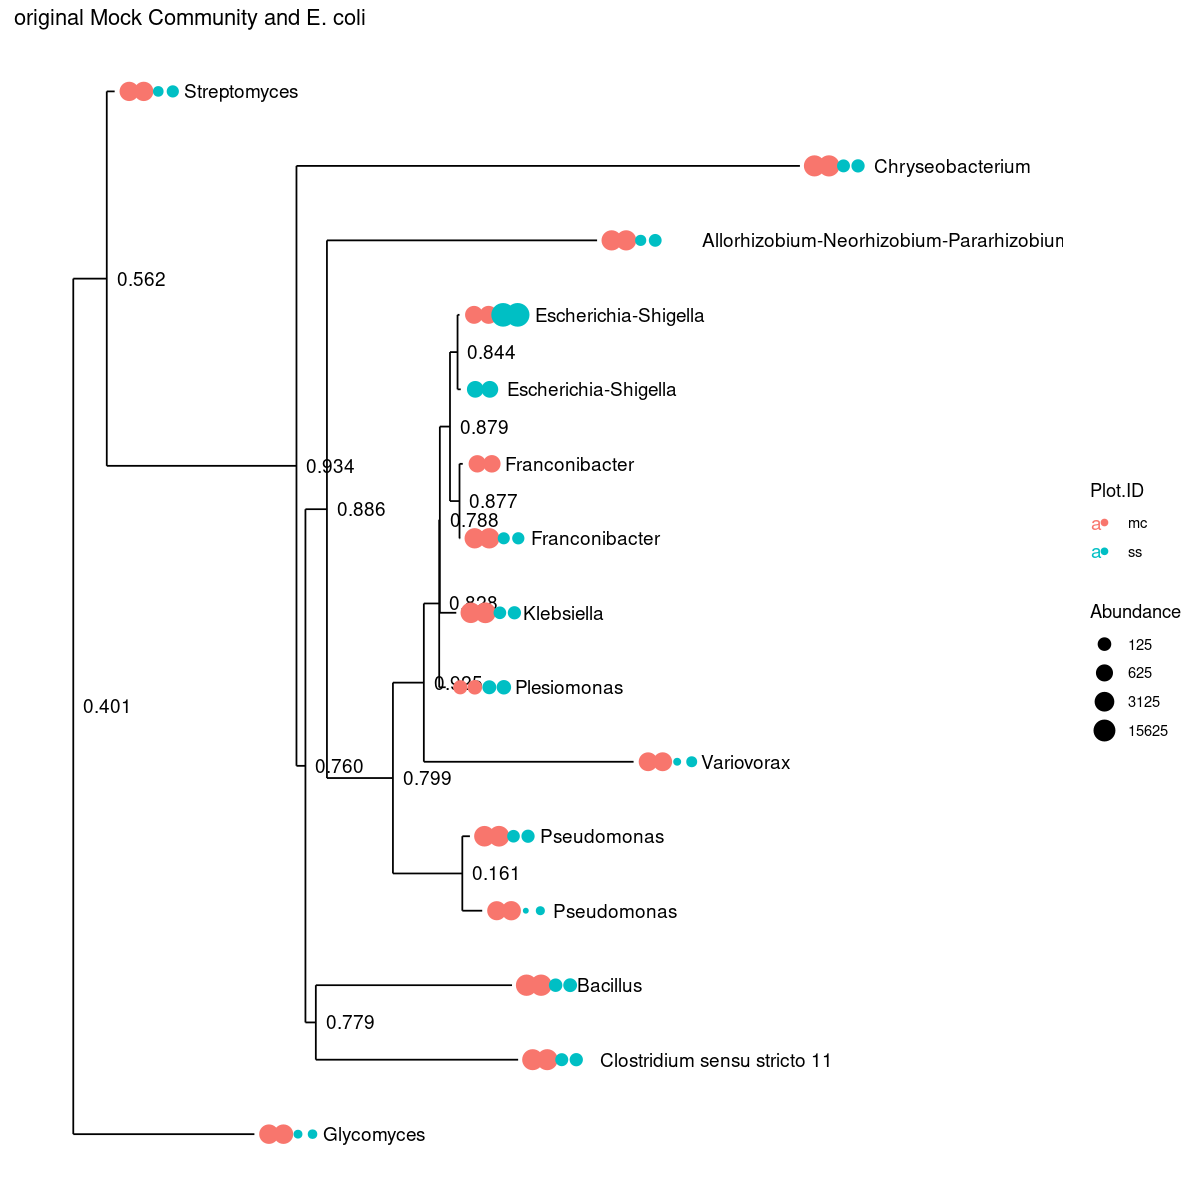

In [26]:
cutoffAbu <- 100
psControls = prune_samples((rownames(sample_data(ps)) %in% c("C1.1","C1.2","C2.1","C2.2")), ps)
psControls = prune_taxa( colSums(otu_table(psControls)) > 0, psControls)
mcOTUs <- taxa_names(psControls)[colSums(otu_table(psControls)[c("C2.1","C2.2"),] > cutoffAbu) == 2]
psControls = prune_taxa( c("ASV1", "ASV1315", mcOTUs), psControls)
sample_data(psControls)$Plot.ID <- c("ss","ss","mc","mc")
plot_tree(psControls, label.tips="Genus", color="Plot.ID", size="abundance", title="original Mock Community and E. coli")



As a first attempt, we can use the default clustering distance given the `tip_glom()` function, with h=0.2:

In [6]:
bb <- tip_glom(ps)

Let's look at what this did to our controls:

In [22]:
cutoffAbu <- 100
cc = prune_samples((rownames(sample_data(bb)) %in% c("C1.1","C1.2","C2.1","C2.2")), bb)
cc = prune_taxa( colSums(otu_table(cc)) > 0, cc)
## retain only those OTUs with high abundances in both MC samples:
mcOTUs <- taxa_names(cc)[colSums(otu_table(cc)[c("C2.1","C2.2"),] > cutoffAbu) == 2]
## reduce to the highly-abundant mock community OTUs, plus the E. coli OTUs 1 and 1315
dd = prune_taxa( c("ASV1","ASV1315",mcOTUs), cc)
sample_data(dd)$Plot.ID <- c("ss","ss","mc","mc")

Using the rankAb plotting function defined above:

[1] 108
[1] 8


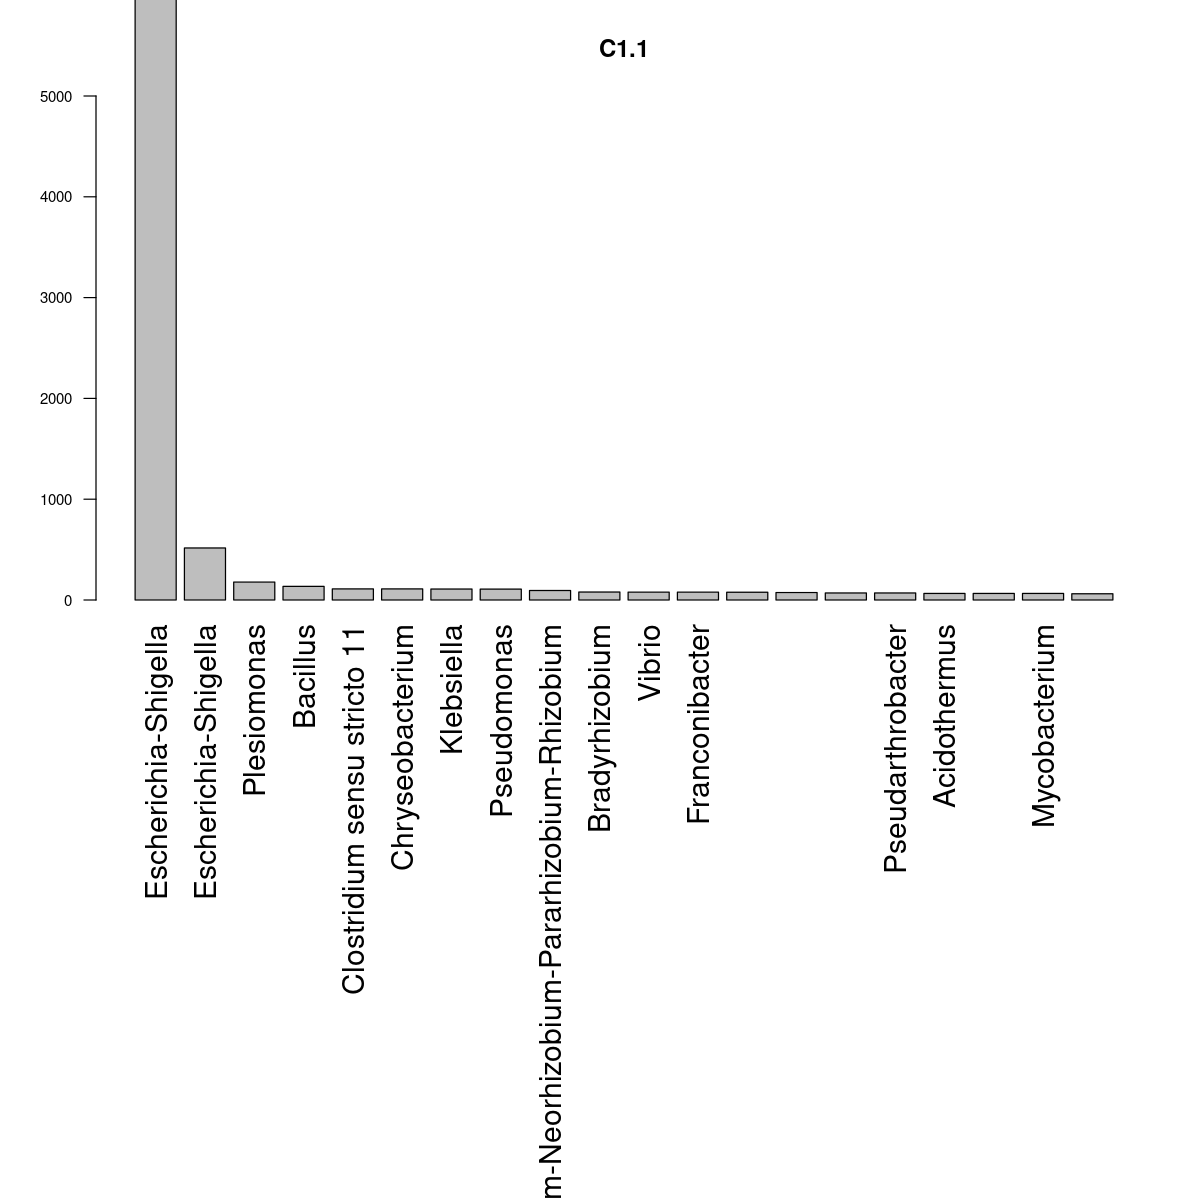

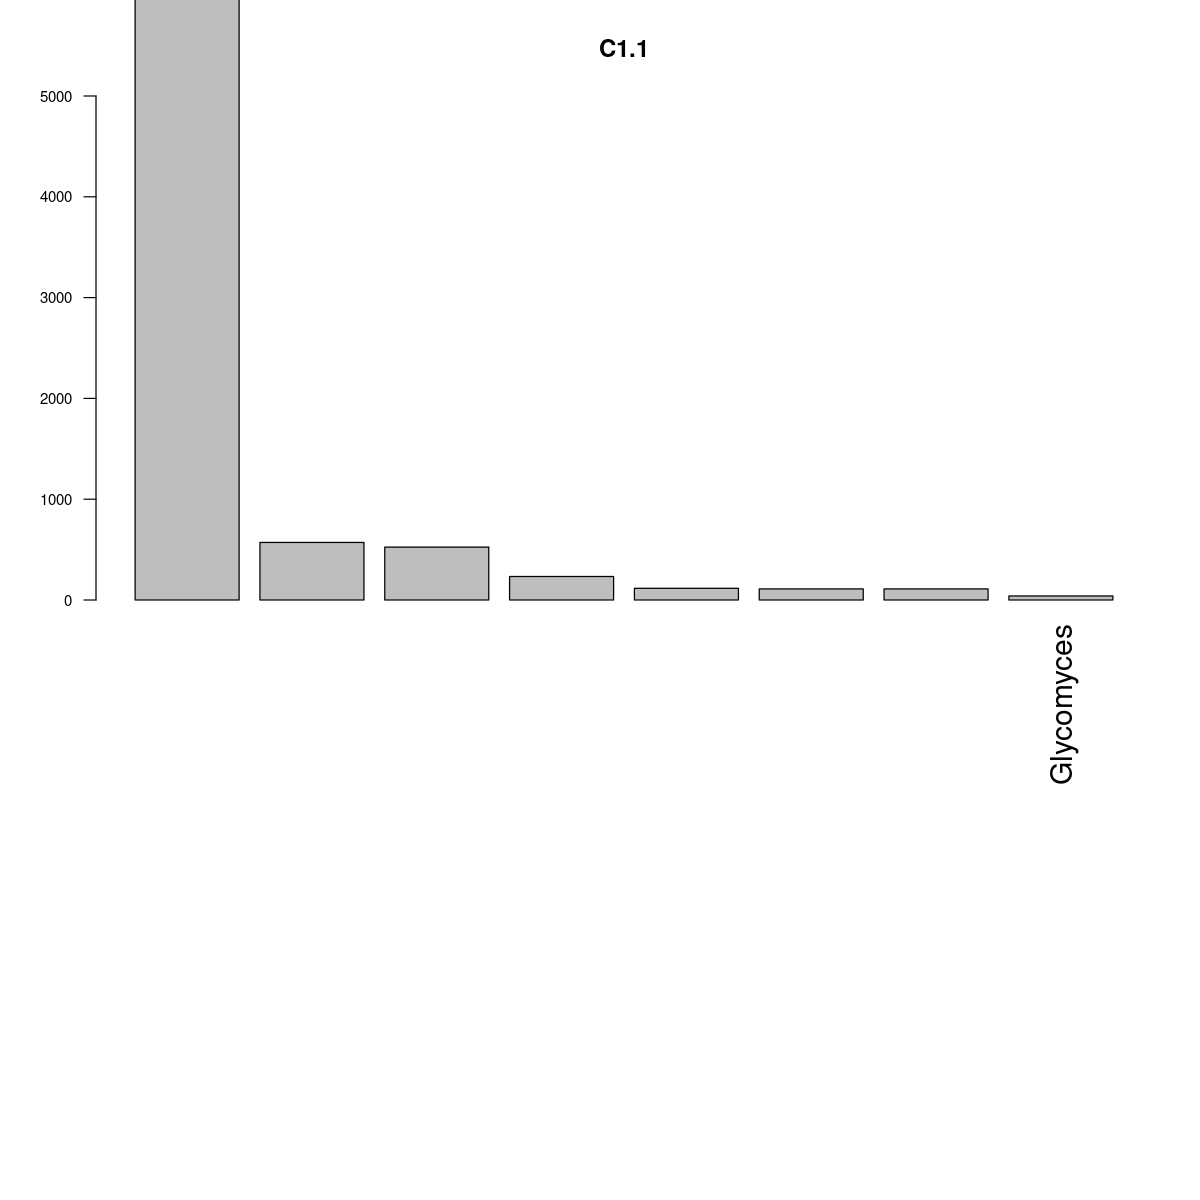

In [25]:
options(repr.plot.width=10, repr.plot.height=10)
par(mfrow = c(1,1))
rankAb(ps,"C1.1", ylimit=5000, ntax=20)
rankAb(dd,"C1.1", ylimit=5000)

Using the default cophenetic distance melted our mock community into some unnamed ASVs, and merged several of them, so there are only 8 of any significant abundance. So the `tip_glom()` defaults are way too large for a "species-level" analysis. After some tweaking, the distance that seems to work best is somewhere around h=0.005.

In [29]:
aa <- read_tree(paste0(spatDir,"/sulariFastTree.nwk"))
phy_tree(ps) <- aa
bb <- tip_glom(ps, h=0.005) 

In [37]:
cutoffAbu <- 100
cc = prune_samples((rownames(sample_data(bb)) %in% c("C1.1","C1.2","C2.1","C2.2")), bb)
cc = prune_taxa( colSums(otu_table(cc)) > 0, cc)
cat("ASV1315 (E. coli) present after tip agglom?:"); "ASV1315" %in% colnames(otu_table(cc))
## retain only those OTUs with high abundances in both MC samples:
mcOTUs <- taxa_names(cc)[colSums(otu_table(cc)[c("C2.1","C2.2"),] > cutoffAbu) == 2]
dd = prune_taxa( c("ASV1",mcOTUs), cc)
sample_data(dd)$Plot.ID <- c("ss","ss","mc","mc")


ASV1315 (E. coli) present after tip agglom?:

[1] FALSE

So the smaller *E. coli* ASV is merged into the larger ASV1:

[1] 13


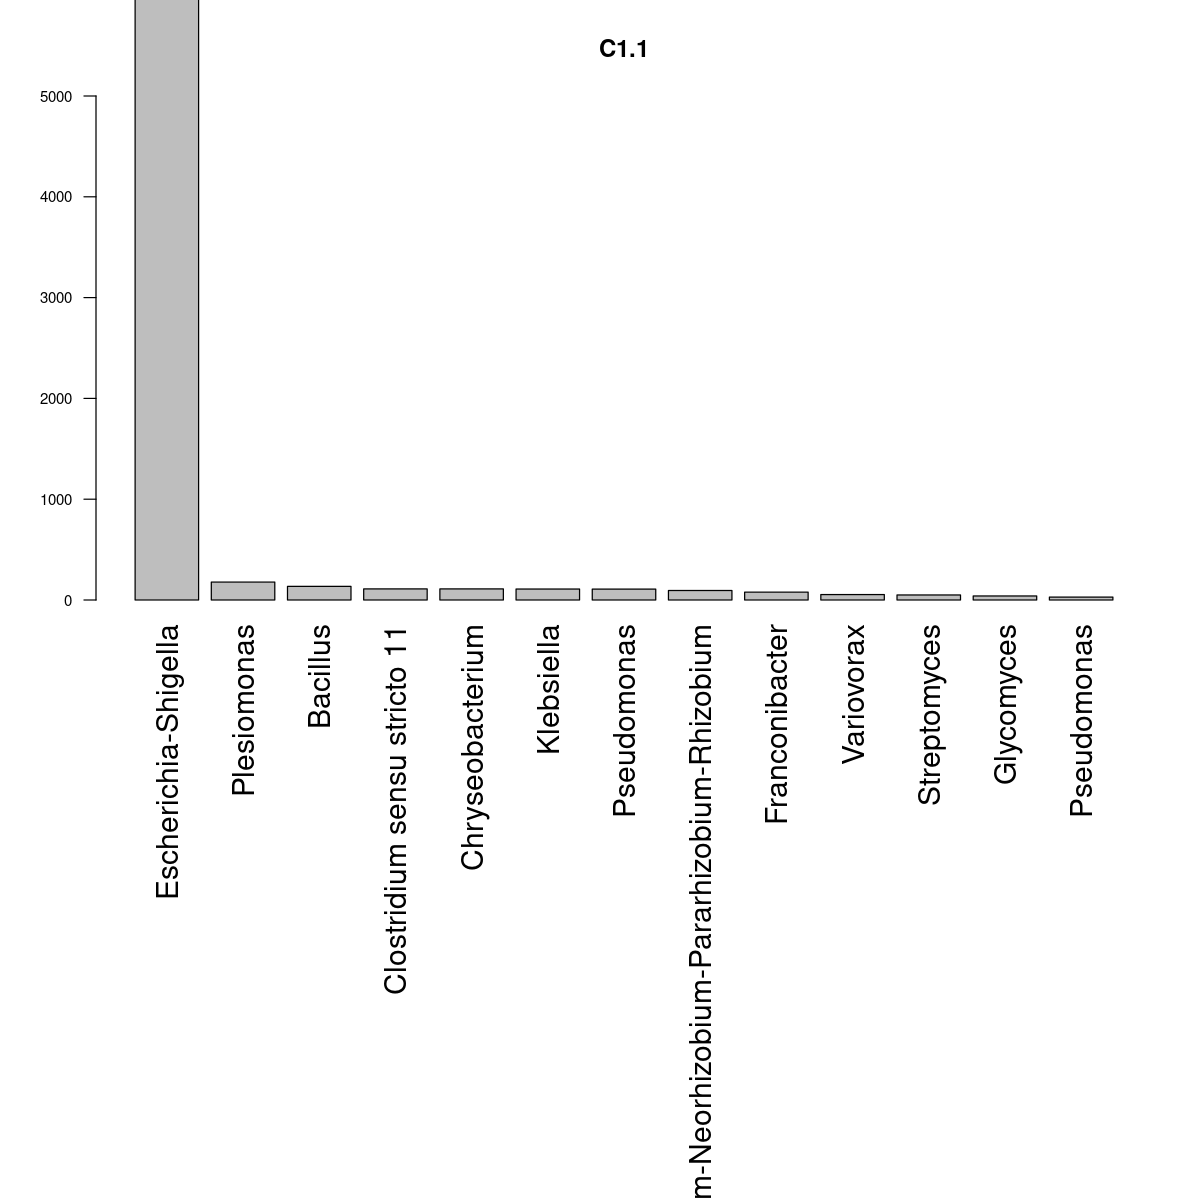

In [38]:
rankAb(dd,"C1.1", ylimit=5000)

[1] 13


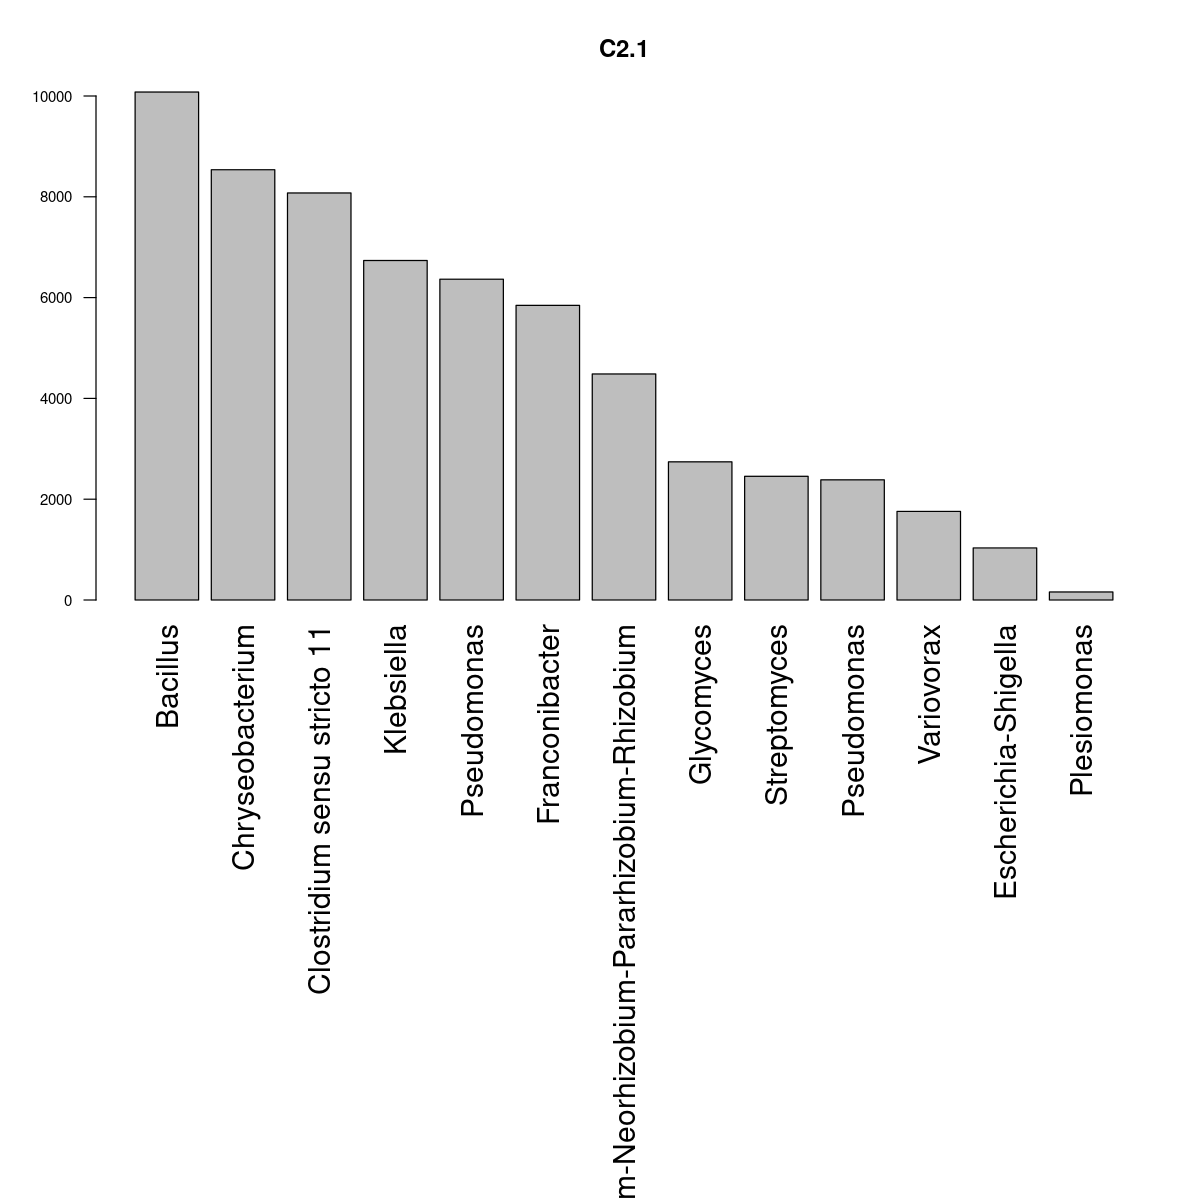

In [34]:
rankAb(dd,"C2.1", ylimit=10000)

Here we see that *Franconibacter* has been merged into one ASV, and *Pseudomonas* ASVs remain separate. The tree of the mock community members and *E. coli* looks a lot better, also:

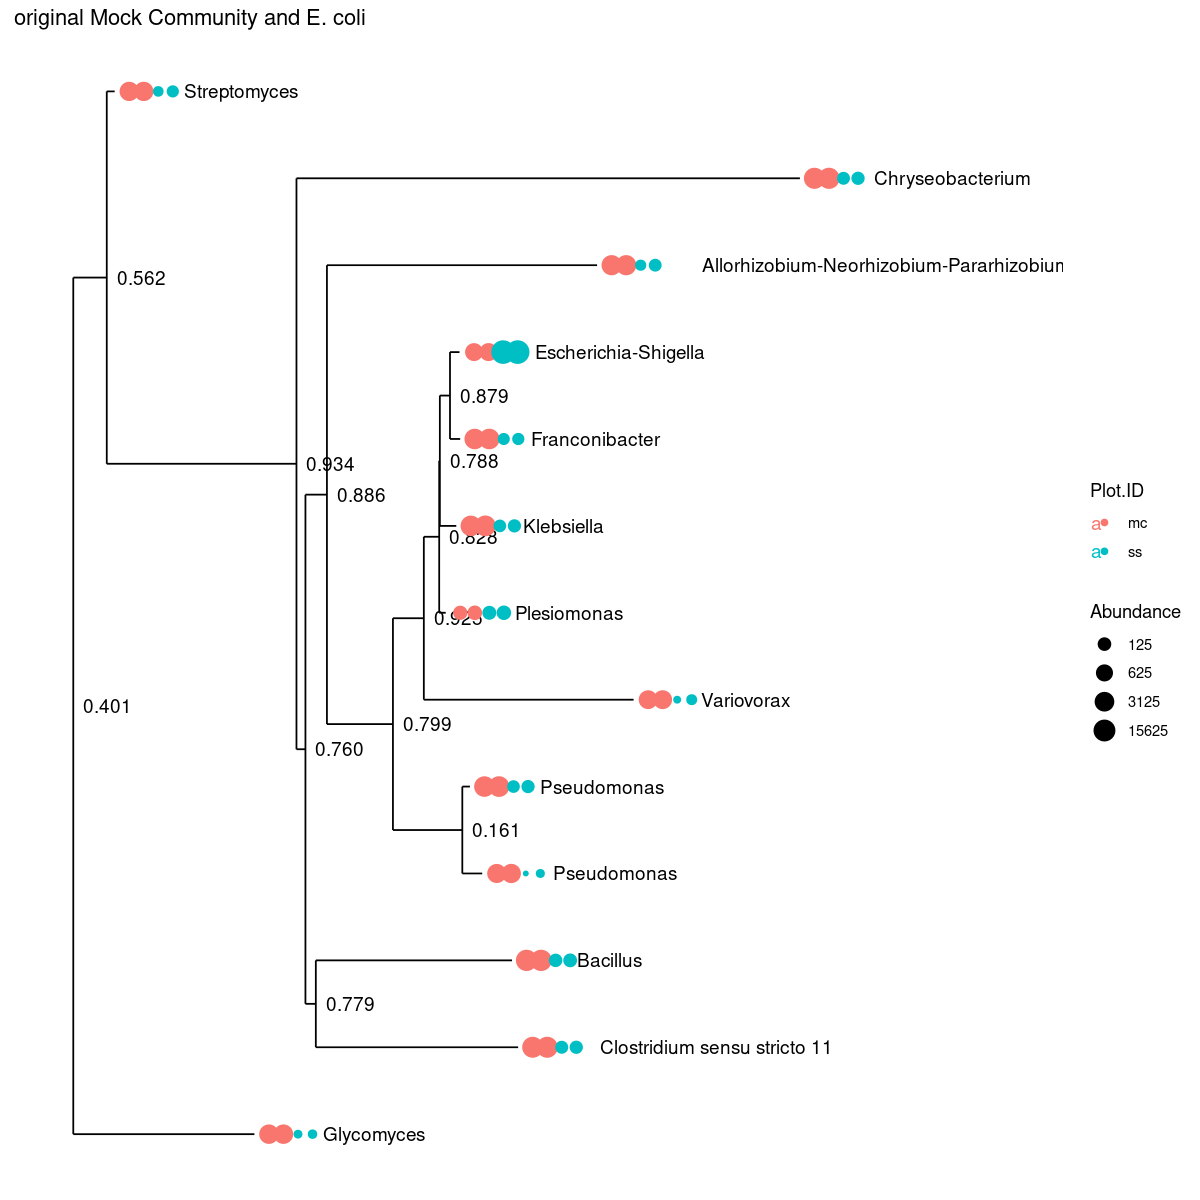

In [39]:
plot_tree(dd, label.tips="Genus", color="Plot.ID", size="abundance", title="original Mock Community and E. coli")


<a id="byeEcoli"><br>
#### Removing overabundant *E. coli* and coalescing Udaeobacter ASVs

Two additional cleaning steps are necessary here. It is obvious that the rest of the samples were contaminated somehow with our singles-species positive control (*E. coli*, ASV1), beyond a level with which we can control with minimum abundances. We can't trust the presence of *E. coli* whereever it is observed in our samples. So we take it out:

In [41]:
notASV1 <- taxa_names(bb) != "ASV1"
bb <- prune_taxa(notASV1, bb)

We also want to consolidate all the various ASVs that are part of the Candidatus Udaeobacter complex, as these may be of interest.

In [44]:
genera <- tax_table(bb)@.Data[,'Genus']
filtUdaeo <- genera == "Candidatus Udaeobacter"
filtUdaeo[is.na(filtUdaeo)]  <- FALSE
udaeoASVs <- names(genera[filtUdaeo])
bb <- merge_taxa(bb, udaeoASVs, 1)
psCleanedUp <- bb

[1] 1


In [45]:
psCleanedUp

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3314 taxa and 124 samples ]
sample_data() Sample Data:       [ 124 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 3314 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3314 tips and 3312 internal nodes ]
refseq()      DNAStringSet:      [ 3314 reference sequences ]

Save this out, as our new "raw" phyloseq object.

In [46]:
save(psCleanedUp, file="psCleanedUP.rda")

<a id="minAbund"></a><br>
#### Make community matrix for general use, decide minimum abundances

For `vegan` and other high-level, non-`HMSC` data exploration, we will want a simple community matrix that has been subjected to the transformations we want. Let's enforce a minimum abundance cutoff informed by the patterns of contamination we observe above, then a normalization by row (= relative abundance by site), and then a log transformation to reduce the importance of highly abundance species. 

We see above that most the cross-contamination of mock community samples into ecological samples that occurred resulted in read counts of less that 50 reads for each contaminant. Let's use that as a cutoff. It will not remove all the contaminants we observe, but we have to balance this against the loss of information that occurs with a high-abundance cutoff. Also, the positive controls have an artifically high amount of reads from the low diversity in them, compared to an ecological sample. Since the contamination we observe seems to be a function of abundance, this means that contamination across samples from natural OTUs originating from our ecological samples are likely to be at a much lower level. Most of our naturally occurring OTUs are at less than 1000 reads in a sample, and usually much less. For example, sample 12:

[1] 898


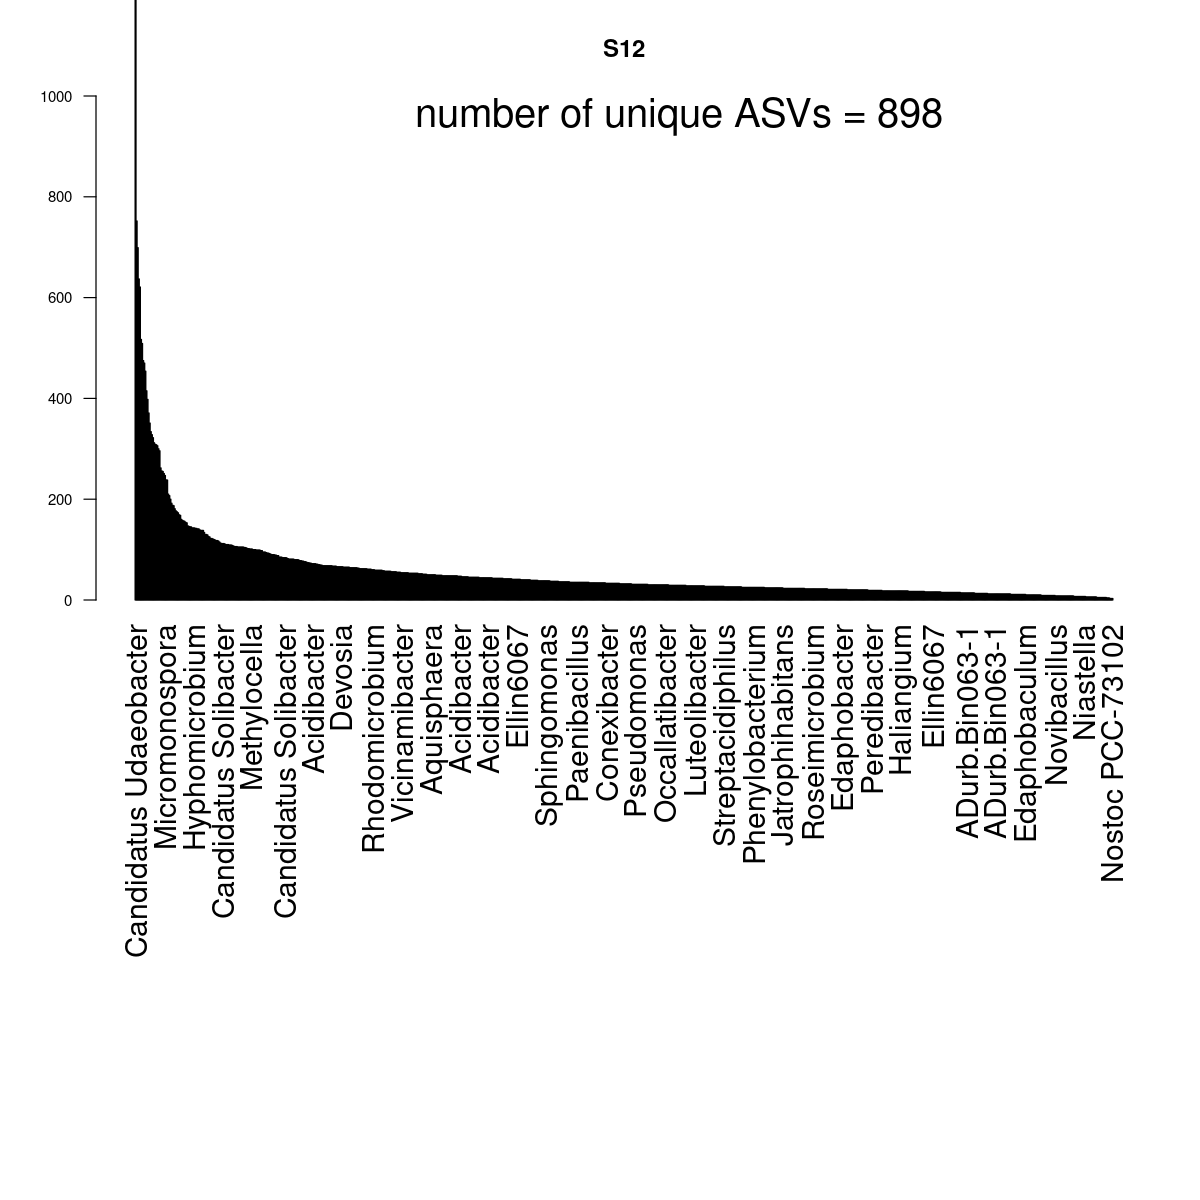

In [54]:
rankAb(psCleanedUp,"S12", ylimit=1000, textatX=600)

So as a compromise we'll enforce a minimum abundance of 50 at each site for each OTU to be considered present. Also apply a log transformation to flatten the hyperabundances.

In [70]:
minCutoff <- 50
ot <- otu_table(psCleanedUp)
ot <- ot - minCutoff
ot[ot < 0] <- 0
psMinCutoff <- psCleanedUp
otu_table(psMinCutoff) <- ot
## normalize by abundances then log to flatten abundance differences
psMinCutoff <- transform_sample_counts(psMinCutoff, function(x) x/sum(x))
## now log transform. Add 1 to avoid the log giving a non-zero 
## value to zero abundances
otu_table(psMinCutoff) <- otu_table(psMinCutoff) + 1
psMinCutoff <- transform_sample_counts(psMinCutoff, log)
## get rid of zero abundance ASVs
psMinCutoff = prune_taxa( taxa_sums(psMinCutoff) > 0, psMinCutoff )
psMinCutoff
## save out a matrix from this

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3257 taxa and 124 samples ]
sample_data() Sample Data:       [ 124 samples by 15 sample variables ]
tax_table()   Taxonomy Table:    [ 3257 taxa by 6 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 3257 tips and 3255 internal nodes ]
refseq()      DNAStringSet:      [ 3257 reference sequences ]

[1] 268


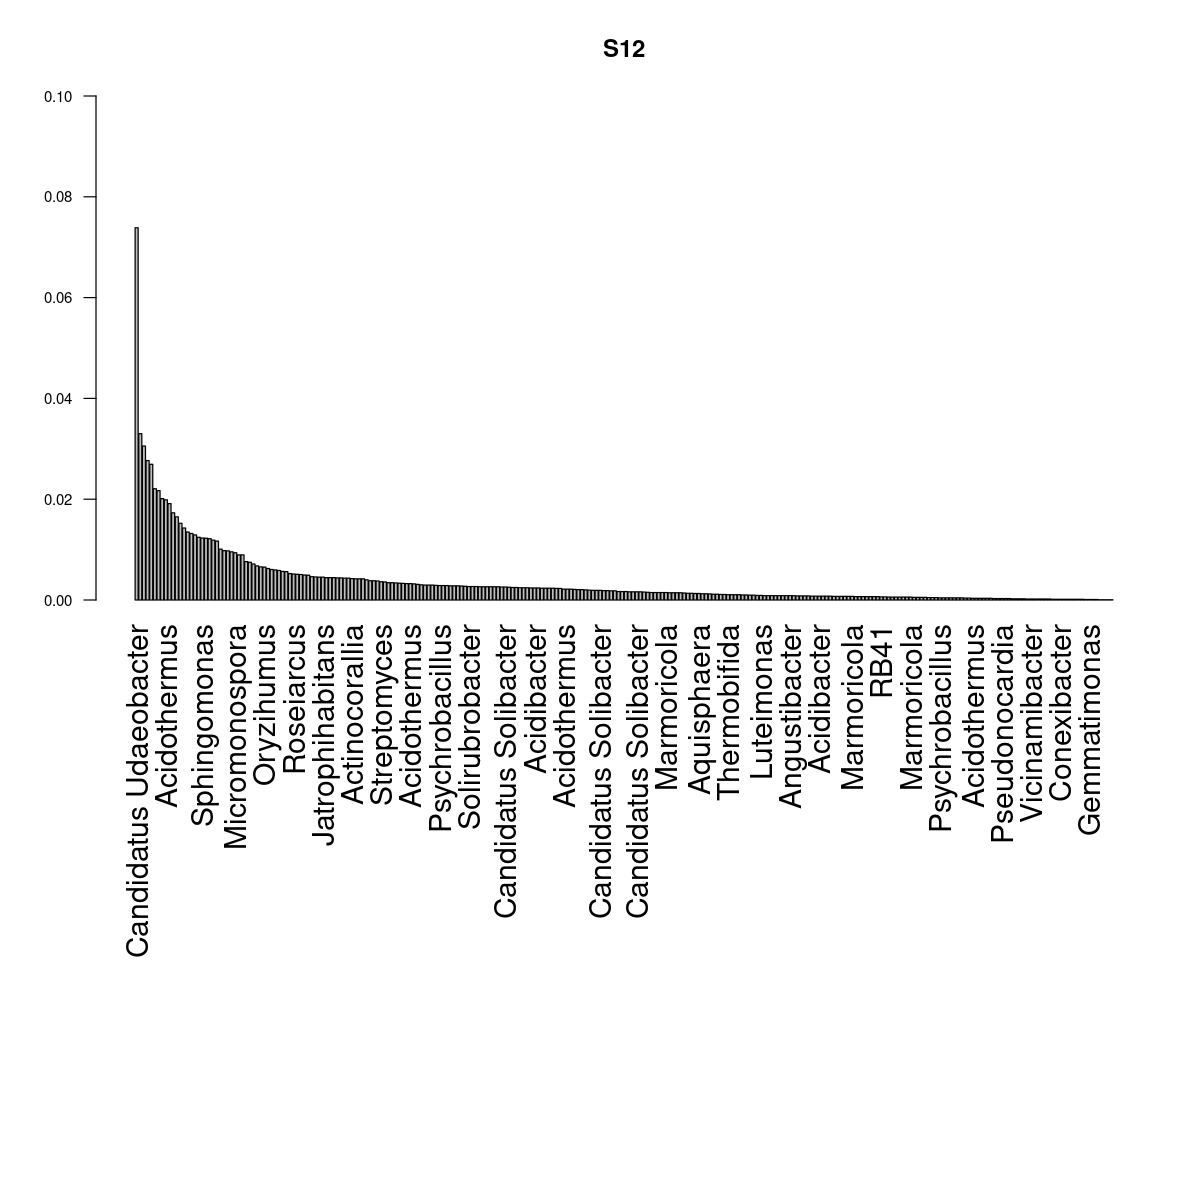

In [73]:
rankAb(psMinCutoff,"S12", ylimit=0.1, textatX=600)

We lose a lot of OTUs even with this cutoff, going from >800 OTUs to 268.

In [78]:
comData <- otu_table(psMinCutoff)@.Data

In [79]:
write.csv(comData, file="/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv")

<id a="baseMap"></a><br>
## Make a map of the sampling effort of Carbon4D

Make a spatial dataframe...

In [15]:
## get rid of controls
envData.drop([ "C1.1", "C1.2", "C2.1", "C2.2"], inplace=True)

plotPoints = gpd.points_from_xy( envData.Longitude, envData.Latitude, crs="EPSG:4326" )

sulariPlotsDF = gpd.GeoDataFrame(envData[[ 'PlotID', 'soil_respiration', 
                    'MBC', 'season', 'Land_type', 'pH', 'N', 'C']], geometry=plotPoints)



## to convert to UTM? looks like we are in zone 33
## looks like:
## EPSG:32633

sulariPlot_utm = sulariPlotsDF.to_crs('EPSG:32633')

sulariPlot_utm.tail()

PlotID  soil_respiration       MBC season   Land_type     pH      N  \
SampleID                                                                       
S116      P0203          1.022541  0.452289     SP      Forest  4.348  0.073   
S117      P0209          1.650842  0.488906     SP      Forest  3.847  0.128   
S118      P0105          1.468438  0.799233     SP  Arableland  5.703  0.165   
S119      P0204          3.054180  0.473599     SP      Forest  3.791  0.157   
S120      P0213          1.067608  0.406645     SP      Forest  4.043  0.110   

              C                        geometry  
SampleID                                         
S116      1.730  POINT (274684.681 5558574.847)  
S117      2.559  POINT (282466.942 5565510.521)  
S118      1.790  POINT (274386.567 5563017.017)  
S119      4.586  POINT (281895.213 5549263.192)  
S120      2.410  POINT (272613.867 5567969.743)

And let's make some maps!

In [16]:
fichtelMap = rasterio.open("studyAreaClipped_UTM.tif")

## color code our points according to land type?
cdik={
"Arableland":"b",
"Grassland":"y",
"Forest":"g",
}
sulariPlotsDF['landColors'] = [ cdik[i] for i in sulariPlotsDF['Land_type'] ]
sulariPlot_utm['landColors'] = [ cdik[i] for i in sulariPlotsDF['Land_type'] ]


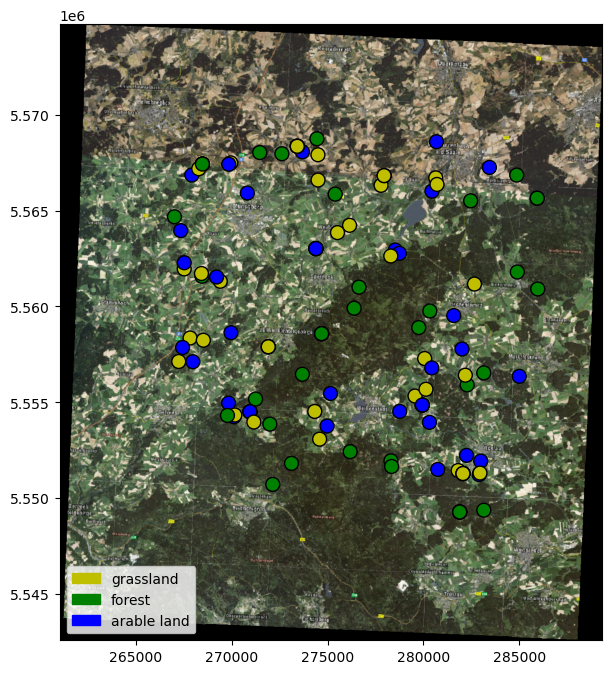

In [17]:
plt.rcParams['figure.figsize'] = [16, 8]
fig, ax = plt.subplots()
rasterio.plot.show(fichtelMap, ax=ax)
sulariPlot_utm.plot(
    marker="o",
    ax=ax,
    edgecolor='k',
    facecolor=sulariPlotsDF['landColors'],
    markersize=100)

grassPatch = Patch(color='y', label='grassland',)
forestPatch = Patch(color='g', label='forest')
farmPatch = Patch(color='b', label='arable land')
ax.legend(handles=[grassPatch, forestPatch, farmPatch],
          loc="lower left",
          fontsize=10,
)





<a id="alphaDiversity"></a><br>
# Alpha diversity

How do our alpha diversities from the various land use types? Preliminary alpha diversity results from Sulari's phyloseq scripts are mixed, at times suggestive of differences in raw species abundance. But our bioinformatics pipeline retains only relatively common species, to reduce error from the sequencer. How does our alpha diversity look after these transformations?

First, let's check rarefaction curves to make sure the samples are actually fair to compare. Did we actually sequence deep enough in all cases to get all the ASVs? We are using our weird, transformed abundances, so let's multiply them and round to get fake counts so that we rarefy:

In [8]:
notControls=!(row.names(comData) %in% c("C1.1", "C1.2", "C2.1", "C2.2"))
comData = comData[notControls,]
envData = envData[notControls,]

In [9]:
min(comData[ comData > 0 ]) ## our smallest non-zero observation 


[1] 1.861833e-05

In [10]:
## so we need to multiply by ~10000 and round up
comDataFakeCounts = ceiling(comData * 10000)
min(comDataFakeCounts[ comDataFakeCounts > 0 ]) ## our smallest non-zero observation is now 1 
max(comDataFakeCounts[ comDataFakeCounts > 0 ]) ## largest single observation of an ASV is now 1724


[1] 1

[1] 1724

[1] 9918

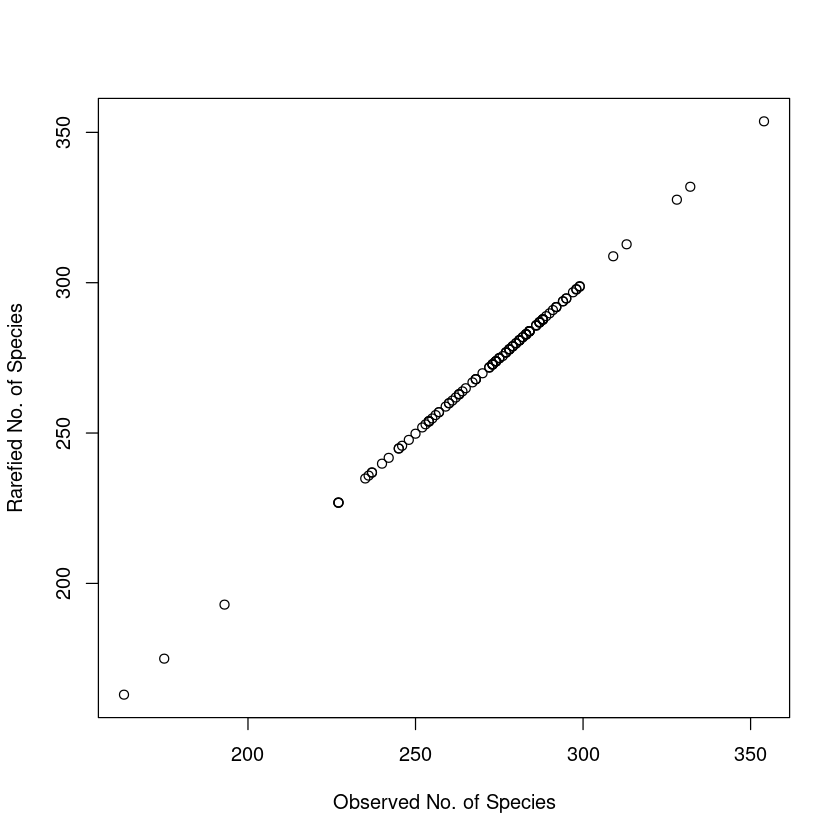

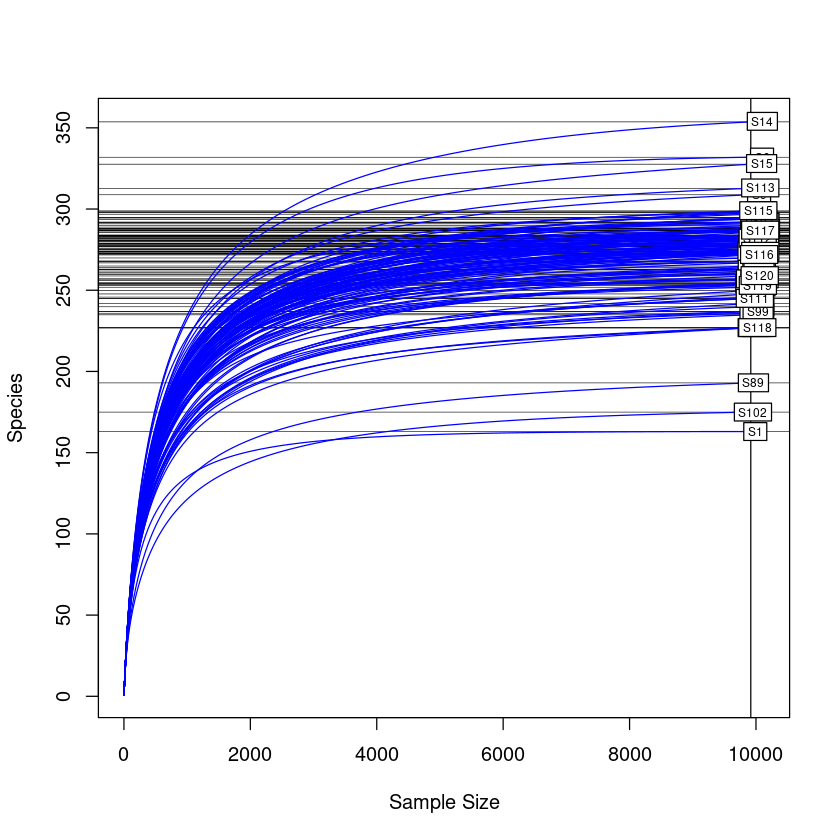

In [12]:
S <- specnumber(comDataFakeCounts) # observed number of species

(raremax <- min(rowSums(comDataFakeCounts))) ## 9918

Srare <- rarefy(comDataFakeCounts, raremax)

plot(S, Srare, xlab = "Observed No. of Species", ylab = "Rarefied No. of Species")

rarecurve(comDataFakeCounts, step = 20, sample = raremax, col = "blue", cex = 0.6)


There is a 100% correlation between total species richness and species observed when rarefied to the same number of individuals. And those are saturated curves even at the number of individuals in the smallest samples. So rarefying isn't really necessary here, these species richness estimates are comparable among all our samples. 

Our numbers of ASVs seem very conservative, 200-350 ASVs/(0.25 g/soil). But makes sense, we have a pretty strict cutoff. This pipeline was intended to maximize comparability among samples for beta diversity analysis and to examine the role of common bacterial species in the soil. If someone asks for the "real" diversity numbers, or a number that includes our best estimate of the number of rare species, we can dig deeper. But I'm not super interested in that at this point.

mean alpha diversity of all sites = 272.2 +/- 25 ASVs

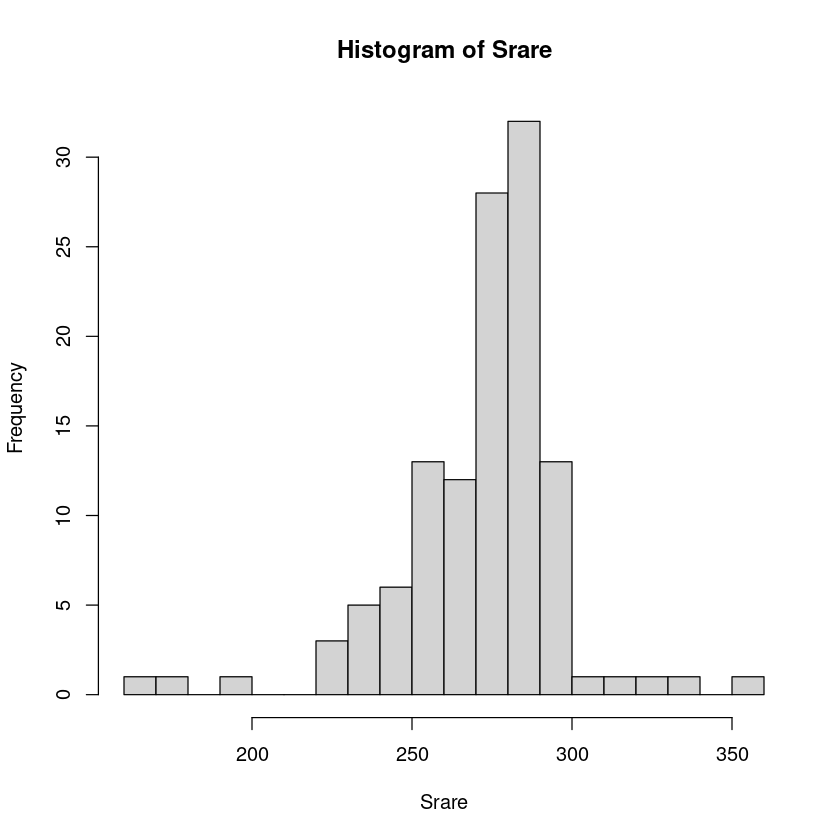

In [13]:
hist(Srare, 20) ## looks more or less normal.
cat(paste("mean alpha diversity of all sites =", round(mean(Srare),2), "+/-", round(sd(Srare)), "ASVs"))


This looks pretty normal. That means we can do a quick one-way ANOVA to check for differences among the land types in species richness.

                   Df Sum Sq Mean Sq F value Pr(>F)
envData$Land_type   2   2933  1466.6   2.308  0.104
Residuals         117  74356   635.5               

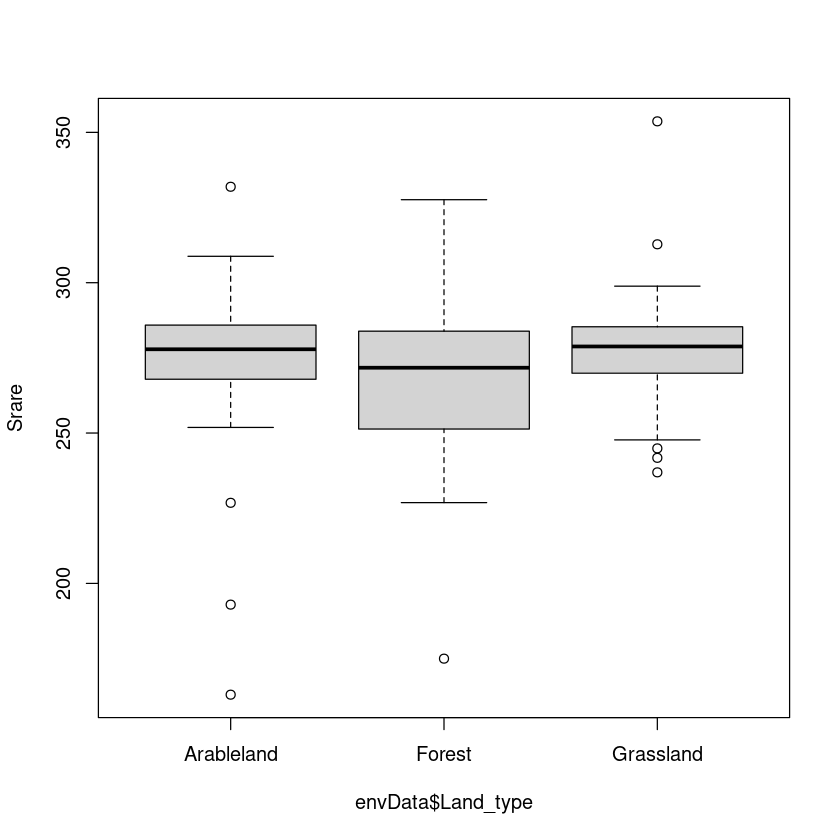

In [16]:
boxplot(Srare ~ envData$Land_type)

## anova
res.aov <- aov(Srare ~ envData$Land_type)
summary(res.aov)


Among the three groups there is not a dramatic difference in alpha diversity. The "near-significance" comes from the contrast between grassland and forest soils:

In [17]:
noFarms <- envData$Land_type != "Arableland"
t.test(Srare[noFarms] ~ envData$Land_type[noFarms])


	Welch Two Sample t-test

data:  Srare[noFarms] by envData$Land_type[noFarms]
t = -2.2416, df = 70.42, p-value = 0.02814
alternative hypothesis: true difference in means between group Forest and group Grassland is not equal to 0
95 percent confidence interval:
 -23.106984  -1.349434
sample estimates:
   mean in group Forest mean in group Grassland 
               265.8069                278.0351 


So as was the case in the Rodriguez paper, the grasslands show a higher alpha diversity than the forest, but see next section on beta diversity.

But let's do this in the Bayesian way...get a posterior for each group and see how much the means differ. We'll use PyMC3 for the bayesian stuff. 

In [10]:
## set kernel to python
controls=[ 'C1.1', 'C1.2', 'C2.1', 'C2.2']
comData.drop(controls, axis='rows', inplace=True)

In [11]:
## remake our species richness here:
aa = comData.copy()
aa[aa > 0] = 1

specRich = aa.sum(axis="columns")

specRichLT = (pd.concat([pd.to_numeric(specRich, downcast='integer'), envData['Land_type']], axis='columns')
                     .rename({0:"spRich"},axis="columns"))

specRichLT.head()

spRich   Land_type
S1     163  Arableland
S2     284   Grassland
S3     246      Forest
S4     263  Arableland
S5     272   Grassland

array([<Axes: >], dtype=object)

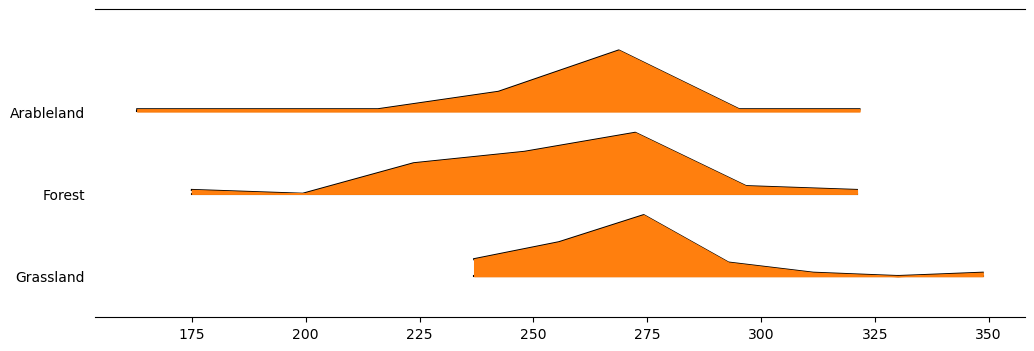

In [13]:
az.plot_forest(specRichLT.pivot(columns="Land_type", values="spRich").to_dict("list"),
               kind="ridgeplot",
               hdi_prob=1,
               colors="C1",
               figsize=(12, 4))


In [15]:
## oswaldo's confusing code for creating an index, adapted for our data:
categories = np.array(["Arableland", "Grassland", "Forest"])
spr = specRichLT["spRich"].values
idx = pd.Categorical(specRichLT["Land_type"], categories=categories).codes
coords = {"Land_type": categories, "land_type_flat":categories[idx]}

## make the model. Use cauchy because of outliers
with pm.Model(coords=coords) as model_t:
    μ = pm.Normal("μ", mu=300, sigma=50, dims="Land_type")
    σ = pm.HalfNormal("σ", sigma=20, dims="Land_type")
    ν = pm.Exponential('ν', 0.1, dims="Land_type") ## exponential gets flatter with lower values, mean gets pulled away from zero
    y = pm.StudentT('Species richness', nu=ν[idx], mu=μ[idx], sigma= σ[idx], observed=spr, dims="land_type_flat")
    idata_cg = pm.sample(random_seed=4591, chains=4)
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg, random_seed=4591))



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [μ, σ, ν]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [Species richness]


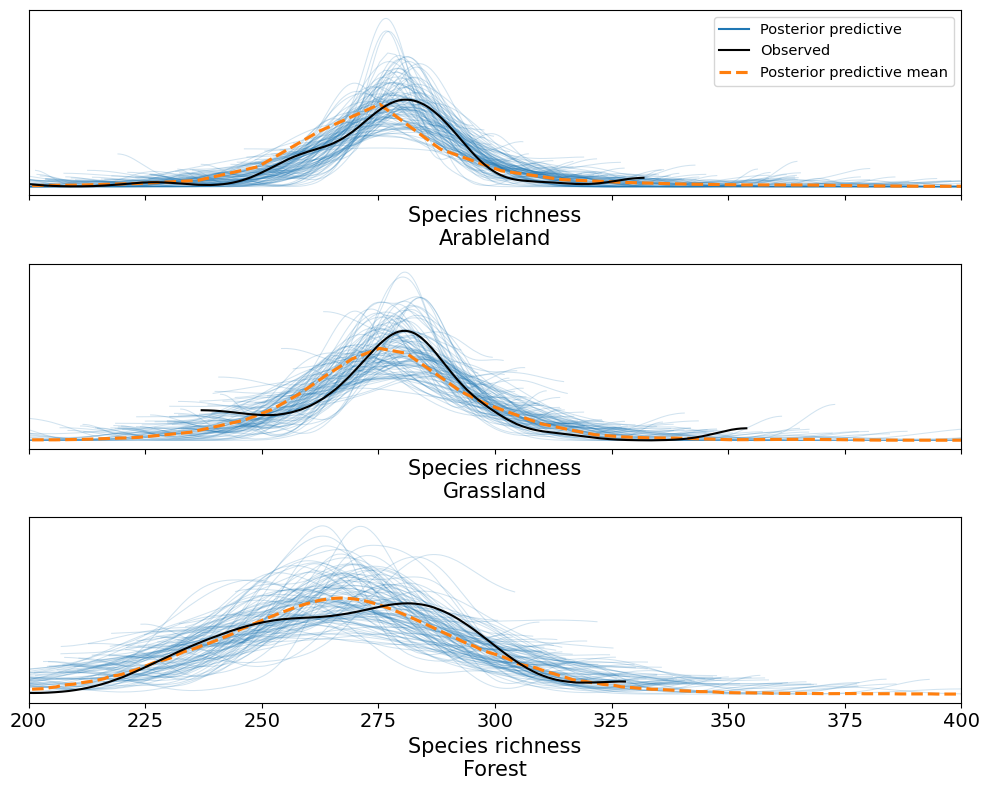

In [16]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(10,8))
az.plot_ppc(idata_cg, num_pp_samples=100, coords={"land_type_flat":[categories]}, flatten=[], ax=axes)
axes[0].set_xlim(200,400)
axes[1].get_legend().remove()
axes[2].get_legend().remove()
fig.tight_layout()


Looks right. Forest has a much greater variation of species richness, also.

<a id="betaDiversity"></a><br>
# Beta-diversity 

<a id="ord"></a><br>
## Ordinations

Let's repeat the ordinations first created by Sulari in her thesis, and add in some info to them. I like the vegan package, so start in R, then move over to python for plotting.

In [4]:
## did you change your kernel to R?
library(vegan)

spatDir <- "/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis"
setwd(spatDir)

comData=read.csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/sulariData/comdat.csv", row.names=1)
envData=read.csv("/home/daniel/Documents/projects/fichtelSoils/fichtelgebirgeSoils/spatialAnalysis/sulariEnv.csv", row.names=1)
## get rid of controls
notControls=!(row.names(comData) %in% c("C1.1", "C1.2", "C2.1", "C2.2"))
comData <- comData[notControls,]
envData <- envData[notControls,]


In [5]:
comNMS <- metaMDS(comData, try=40)

write.csv(comNMS$points, file='comNMS.csv')

Run 0 stress 0.06024971 
Run 1 stress 0.06175813 
Run 2 stress 0.0637531 
Run 3 stress 0.06551715 
Run 4 stress 0.06212034 
Run 5 stress 0.0610971 
Run 6 stress 0.06443119 
Run 7 stress 0.06285261 
Run 8 stress 0.06271244 
Run 9 stress 0.06663888 
Run 10 stress 0.06600763 
Run 11 stress 0.06625445 
Run 12 stress 0.06443834 
Run 13 stress 0.06406489 
Run 14 stress 0.06249153 
Run 15 stress 0.06684139 
Run 16 stress 0.06684022 
Run 17 stress 0.06598824 
Run 18 stress 0.06264544 
Run 19 stress 0.06379528 
Run 20 stress 0.06199215 
*** Best solution was not repeated -- monoMDS stopping criteria:
     2: no. of iterations >= maxit
    15: stress ratio > sratmax
     3: scale factor of the gradient < sfgrmin


In python...

In [4]:
## data
nmsPts = pd.read_csv("comNMS.csv", index_col=0)
controls=[ 'C1.1', 'C1.2', 'C2.1', 'C2.2']
comData.drop(controls, axis='rows', inplace=True)


First ordination is just land use:

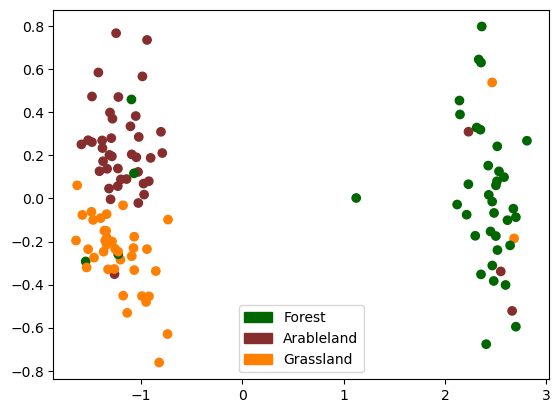

In [5]:
colorDict = {
'Arableland':'#862d2d',
'Forest'    :'#006600',
'Grassland' :'#FF7F00'
}
landCols = [ colorDict[i] for i in envData['Land_type'] ]

plt.close('all')
fig, ax = plt.subplots()
ax.scatter(x=nmsPts["MDS1"],
           y=nmsPts["MDS2"],
           c=landCols,
          )

Arableland_patch = Patch(color='#862d2d', label='Arableland')
Forest_patch = Patch(color='#006600', label='Forest')
Grassland_patch = Patch(color='#FF7F00', label='Grassland')
ax.legend(handles=[Forest_patch, Arableland_patch, Grassland_patch])


Pretty clear separation of microbial communities by land type. 

There are samples in this dataset from different communities. Does this make much difference, at least in the ordinations?

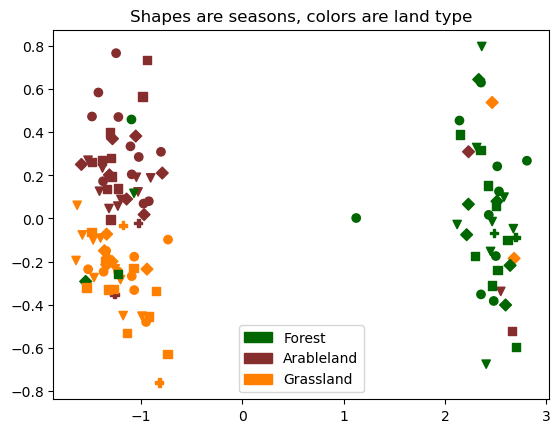

In [6]:
seasonDict = {
     'S': "o",
    'SP': "v",
    'W1': "D",
    'W2': "P",
     'A': "s",
}

fig, ax = plt.subplots()
for i in envData.season.unique():
  env_i = envData[envData['season'] == i]
  plots_i = env_i.index.to_list()
  nmsPts_i = nmsPts.loc[plots_i]
  cols_i = [ colorDict[i] for i in env_i['Land_type'] ]
  ax.scatter(x=nmsPts_i["MDS1"],
             y=nmsPts_i["MDS2"], 
             c=cols_i,
        marker=seasonDict[i],
            )


ax.set_title('Shapes are seasons, colors are land type')
Arableland_patch = Patch(color='#862d2d', label='Arableland')
Forest_patch = Patch(color='#006600', label='Forest')
Grassland_patch = Patch(color='#FF7F00', label='Grassland')
ax.legend(handles=[Forest_patch, Arableland_patch, Grassland_patch])


Doesn't seem like a dramatic effect, but further investigation needed.

Let's also visualize pH and respiration. We will indicate pH by color, land type by symbol, and respiration by size:

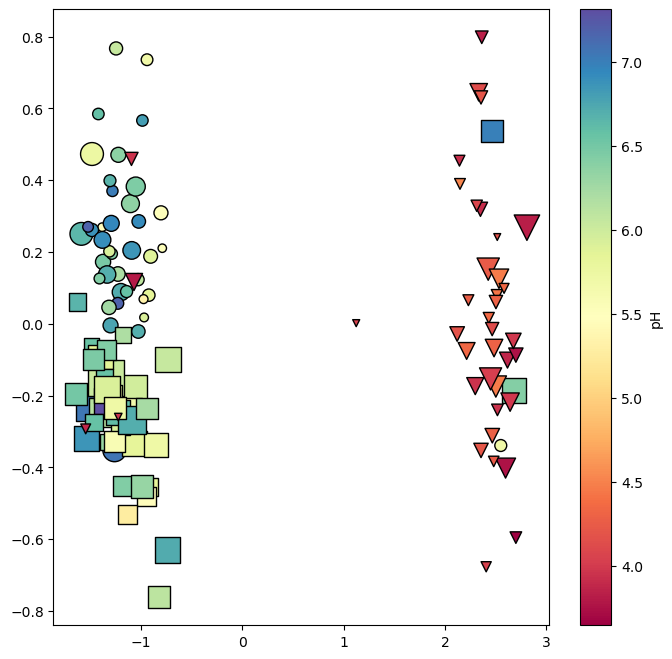

In [7]:
landTypeShapesDict = {
'Arableland': "o",
'Forest'    : "v",
'Grassland' : "s",
}

pHmin = envData['pH'].min() ## 3.647
pHmax = envData['pH'].max() ## 7.312
norm=matplotlib.colors.Normalize(pHmin, pHmax)
plt.close('all')
fig, ax = plt.subplots(figsize=(8,8))
for i in envData.Land_type.unique():
  env_i = envData[envData['Land_type'] == i]
  plots_i = env_i.index.to_list()
  nmsPts_i = nmsPts.loc[plots_i]
  sizes = env_i['soil_respiration']*50
  ax.scatter(x=nmsPts_i["MDS1"],
             y=nmsPts_i["MDS2"],
             #s=140,
             s=sizes,
             c=env_i['pH'],
             cmap='Spectral',
             edgecolors='black',
             marker=landTypeShapesDict[i],
             norm=norm,
            )

fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(pHmin, pHmax), cmap='Spectral'),
             ax=ax, orientation='vertical', label='pH')


Squares are grassland, circles are cropland, and triangles are forest. Color is pH. Size is scaled to respiration/g. There is a clear signature of low pH in the forest soils, which isn't really a surprise. The grasslands are clearly respiring more, on average. 

<a id="comTurnover"></a><br>
## Community turnover

We predict that forest soils show higher community turnover than grasslands and maybe cropland, because of the more sheltered but more complex forest environment. Total community turnover across the entire study looks like this:

In [10]:
plotPoints = gpd.points_from_xy( envData.Longitude, envData.Latitude, crs="EPSG:4326" )
sulariPlotsDF = gpd.GeoDataFrame(envData[[ 'PlotID', 'soil_respiration',
                    'MBC', 'season', 'Land_type', 'pH', 'N', 'C']], geometry=plotPoints)

sulariPlot_utm = sulariPlotsDF.to_crs('EPSG:32633')
fichtelMap = rasterio.open("studyAreaClipped_UTM.tif")


Text(0.5, 0, 'Physical distance (m) between sites')

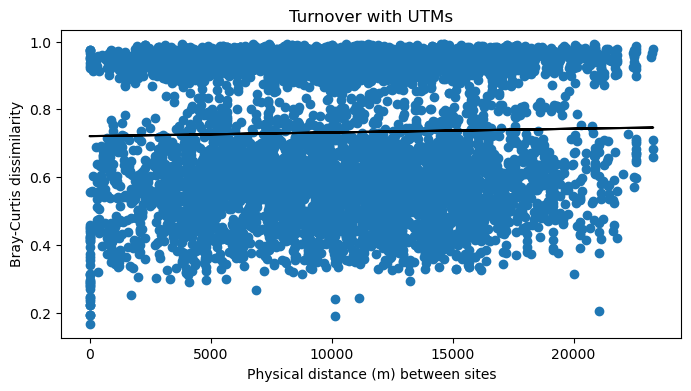

In [11]:
plt.rcParams['figure.figsize'] = [8, 4]
aa = pd.DataFrame({'xx':sulariPlot_utm.geometry.x, 'yy':sulariPlot_utm.geometry.y})
physDist = sp.distance.pdist(aa, metric='euclidean')
bcDist = sp.distance.pdist(comData, metric='brayCurtis')
fig, ax = plt.subplots()
ax.scatter(physDist, bcDist)
X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
ax.plot( X, LinearRegression().fit(X, Y).predict(X), c='k')
ax.set_title(label="Turnover with UTMs", loc='center')
ax.set_ylabel("Bray-Curtis dissimilarity")
ax.set_xlabel("Physical distance (m) between sites")


Pretty flat. BC stays around .75 across the study. But if we break this up by land use: 

Arableland LinregressResult(slope=2.7359475613765417e-06, intercept=0.5474468448742715, rvalue=0.07235324847530483, pvalue=0.03377519490998856, stderr=1.286806964083919e-06, intercept_stderr=0.014221931497617938)
Grassland LinregressResult(slope=4.0360780896213794e-07, intercept=0.5299241927493024, rvalue=0.011734810541160908, pvalue=0.7497957644448039, stderr=1.2651189306102426e-06, intercept_stderr=0.014273723772298666)
Forest LinregressResult(slope=6.358726643304543e-06, intercept=0.5841355747413846, rvalue=0.20949839745390303, pvalue=8.55205699529346e-09, stderr=1.091745114077608e-06, intercept_stderr=0.013367819585535323)


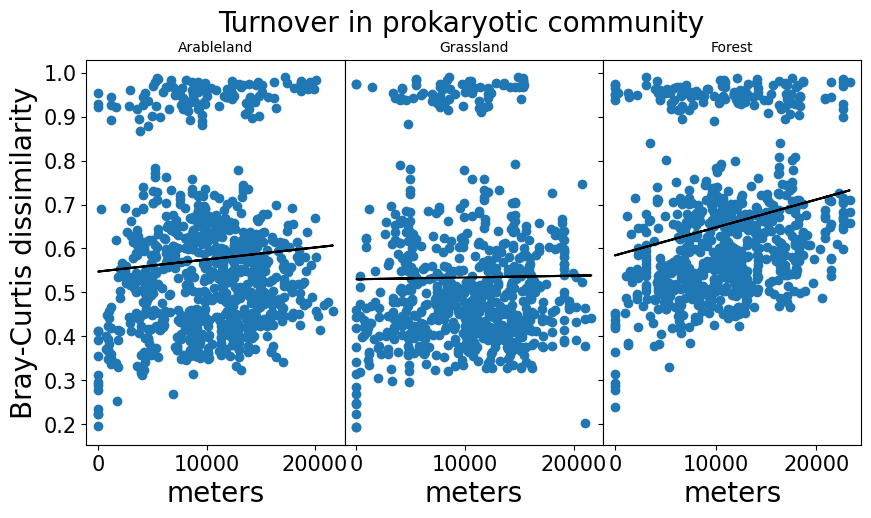

In [13]:
plt.rcParams['figure.figsize'] = [10, 5]
plt.rc('ytick', labelsize=15)
plt.rc('xtick', labelsize=15)
lts = [ "Arableland" ,"Grassland" ,"Forest"]
#lts = [ "Grassland" ,"Forest"]
fig, axes = plt.subplots(nrows=1, ncols=len(lts), sharey=True)
axes = axes.flatten()
for nu,lt in enumerate(lts):
    edf = sulariPlot_utm[sulariPlot_utm['Land_type'] == lt]
    cdf = comData.loc[edf.index]
    aa = pd.DataFrame({'xx':edf.geometry.x, 'yy':edf.geometry.y})
    physDist = sp.distance.pdist(aa, metric='euclidean')
    bcDist = sp.distance.pdist(cdf, metric='brayCurtis')
    axes[nu].scatter(physDist, bcDist)
    X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
    linMod =  LinearRegression().fit(X, Y)
    axes[nu].plot( X, linMod.predict(X), c='k')
    axes[nu].set_title(label=lt, size=10, loc='center')
    axes[nu].set_xlabel('meters', size=20)
    print(lt, stats.linregress(physDist,bcDist))


fig.suptitle("Turnover in prokaryotic community", size=20)
axes[0].set_ylabel('Bray-Curtis dissimilarity', size=20)
axes[1].tick_params(left=False, labelleft=False, right=True, labelright=True, color='red', axis='y')
plt.subplots_adjust(wspace = 0)



Forest shows a higher community turnover across space and higher dissimilarity among sites generally. 

<a id="gammaDiversity"></a><br>
# Gamma diversity

Let's run some total diversity estimates, for the study at large, and subsetted by land type. We'll use the vegan package in R for the statistics.

In [5]:
## set kernel to R
notControls=!(row.names(comData) %in% c("C1.1", "C1.2", "C2.1", "C2.2"))
comData <- comData[notControls,]
envData <- envData[notControls,]
all(row.names(comData) == row.names(envData))

[1] TRUE

Warning message in cor(x > 0):
“the standard deviation is zero”


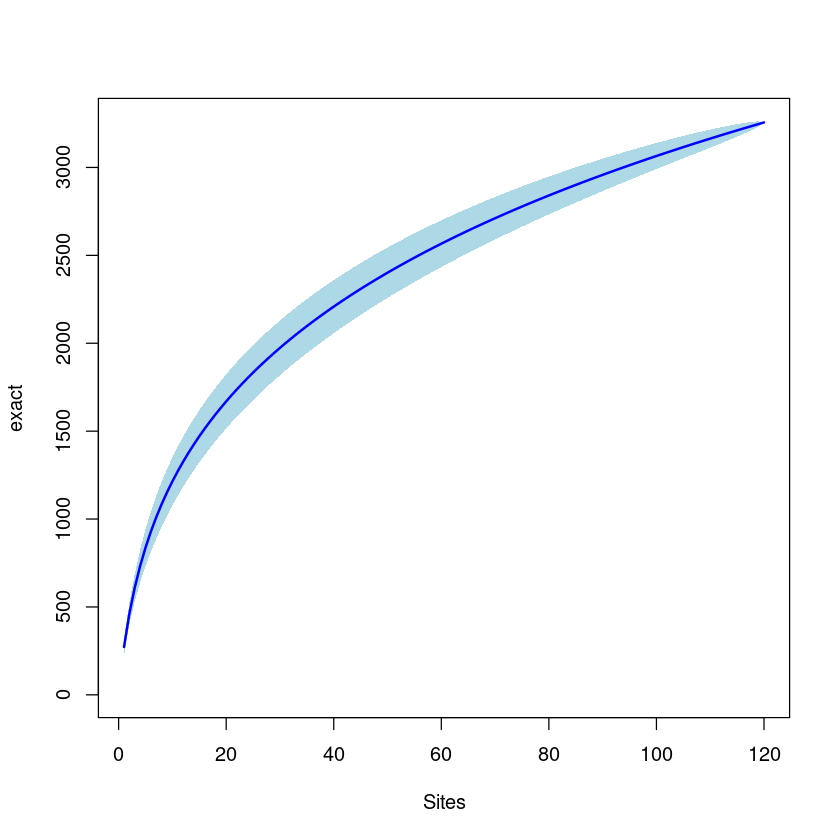

In [6]:
## if same order rows...
## get rid of controls
notControls=!(row.names(comData) %in% c("C1.1", "C1.2", "C2.1", "C2.2"))
comData = comData[notControls,]
envData = envData[notControls,]

sp1 <- specaccum(comData)

plot(sp1, ci.type="poly", col="blue", lwd=2, ci.lty=0, ci.col="lightblue")


Doesn't look saturated. Species estimaters:

In [7]:
specpool(comData)

Species chao     chao.se  jack1  jack1.se jack2    boot     boot.se  n  
All 3256    4532.658 105.1671 4315.1 127.8194 4933.344 3721.852 67.12903 120

But this isn't really meaningful, one of my main hypotheses is that soil from different sites will contribute differently to gamma diversity. Let's use vegan to make our data, but go into python for plotting, it's better.

In [8]:
for (lt in c('Arableland','Grassland', 'Forest')){
    print(lt)
    justThisLandtype=row.names(envData[envData['Land_type'] == lt,])
    comm.i <- comData[ justThisLandtype,]
    specAccum.i <- specaccum(comm.i)
    SACdf.i <- data.frame(specAccum.i$richness, specAccum.i$sd)
    colnames(SACdf.i) <- c('richness', 'sd')
    speciesEstimators.i = specpool(comm.i)
    print(speciesEstimators.i)
    write.csv(SACdf.i, file=paste(lt, "SAC.csv", sep="_"))
    write.csv(speciesEstimators.i, file=paste(lt, "specEst.csv", sep="_"))
}


[1] "Arableland"


Warning message in cor(x > 0):
“the standard deviation is zero”


    Species     chao  chao.se jack1 jack1.se    jack2     boot  boot.se  n
All    1843 2701.031 86.72472  2540 176.5745 2950.546 2148.855 99.61256 42
[1] "Grassland"


Warning message in cor(x > 0):
“the standard deviation is zero”


    Species     chao  chao.se    jack1 jack1.se    jack2     boot  boot.se  n
All    1616 2333.516 77.53404 2220.103 168.4037 2567.209 1880.473 98.62829 39
[1] "Forest"


Warning message in cor(x > 0):
“the standard deviation is zero”


    Species     chao  chao.se    jack1 jack1.se    jack2     boot  boot.se  n
All    1987 3026.563 96.66417 2813.256 188.8072 3306.465 2347.423 104.4077 39


Now move to matplotlib (python)...

In [3]:
def plotSACs(habtype, color='black', ax=None):
    if ax is None: fig, ax = plt.subplots()
    sacs = [ i for i in os.listdir() if "_SAC.csv" in i  ]
    sacName = (habtype +'_SAC.csv')
    assert( (habtype +'_SAC.csv') in sacs)
    specEstName = (habtype + "_specEst.csv")
    sac_i = pd.read_csv(sacName, index_col=0)
    specEst_i = pd.read_csv(specEstName, index_col=0).loc['All']
    specEst_i.index = specEst_i.index.str.replace(".","_")
    X = sac_i.index
    ax.plot(X, sac_i['richness'], color=color)
    ax.fill_between(x=X,
                     y1=sac_i.richness - sac_i.sd,
                     y2=sac_i.richness + sac_i.sd,
                    alpha=0.4,
                    color=color,
                    )

Text(0, 0.5, 'Prokaryotic ASVs')

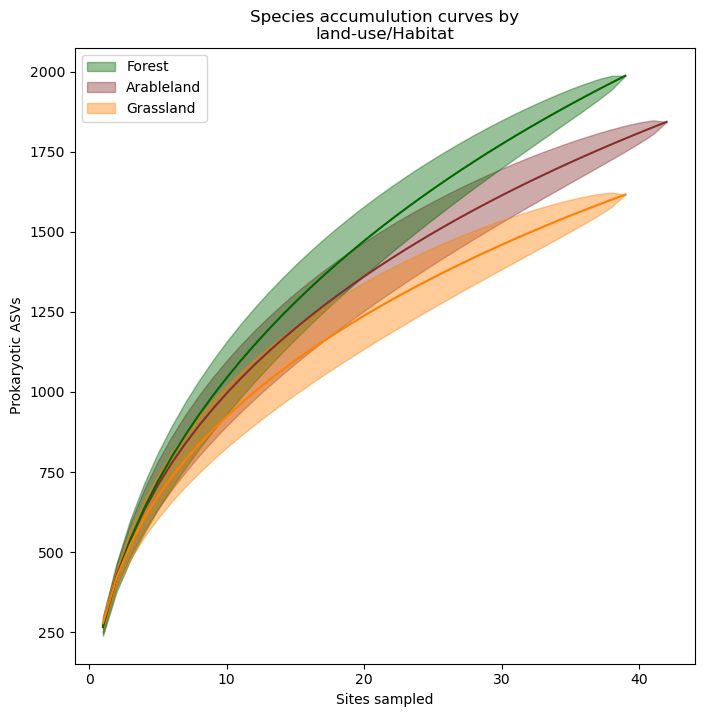

In [4]:
fig, ax = plt.subplots(figsize=(8,8))
plotSACs('Arableland', ax=ax, color='#862d2d')
plotSACs('Forest', ax=ax, color='#006600')
plotSACs('Grassland', ax=ax, color='#FF7F00')

Arableland_patch = Patch(color='#862d2d', label='Arableland', alpha=0.4)
Forest_patch = Patch(color='#006600', label='Forest', alpha=0.4)
Grassland_patch = Patch(color='#FF7F00', label='Grassland', alpha=0.4)

ax.legend(handles=[Forest_patch, Arableland_patch, Grassland_patch])
ax.set_title('Species accumulution curves by\nland-use/Habitat')
ax.set_xlabel('Sites sampled')
ax.set_ylabel('Prokaryotic ASVs')

Forests, if equally and sufficiently sampled within the region, are expected to show significantly more species richness that agricultural and especially grassland soils.

<a id="resp"></a><br>
# Respiration

<a id="respMap"></a><br>
## Respiration spatial trends

First step: make a map.

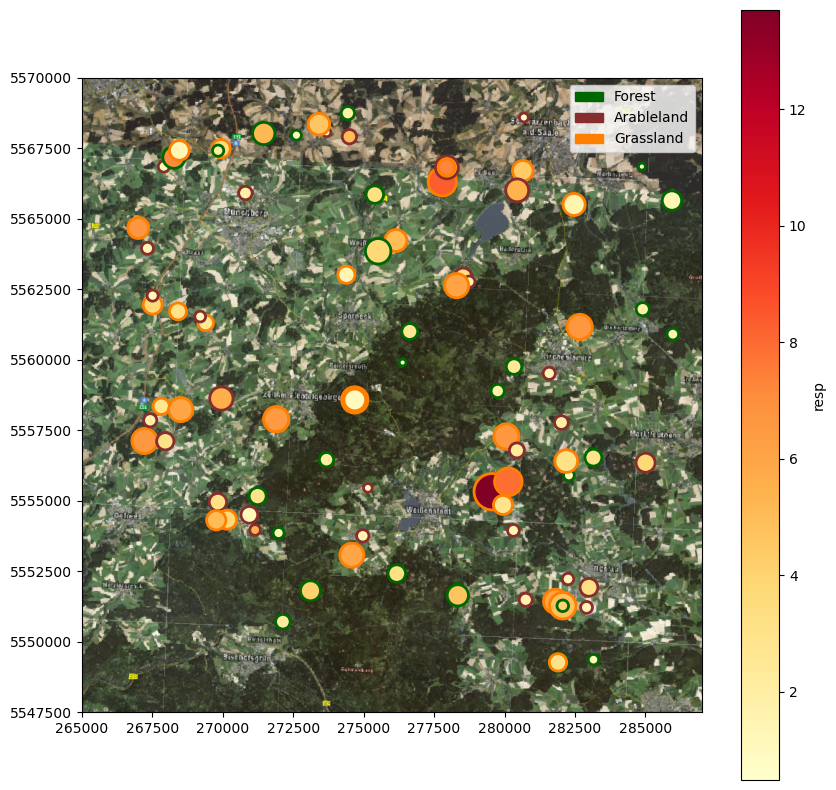

In [5]:
## get a geopandas spdf
plotPoints = gpd.points_from_xy( envData.Longitude, envData.Latitude, crs="EPSG:4326" )
sulariPlotsDF = gpd.GeoDataFrame(envData[[ 'PlotID', 'soil_respiration',
                    'MBC', 'season', 'Land_type', 'pH', 'N', 'C']], geometry=plotPoints)

sulariPlot_utm = sulariPlotsDF.to_crs('EPSG:32633')

## this map is all we have for a background right now.
fichtelMap = rasterio.open("studyAreaClipped_UTM.tif")

landColorDict = {
'Arableland':'#862d2d',
'Forest'    :'#006600',
'Grassland' :'#FF7F00'
}
landCols = [ landColorDict[i] for i in sulariPlot_utm['Land_type'] ]

fig, ax = plt.subplots(figsize=(10,10))
rasterio.plot.show(fichtelMap, ax=ax)
ax.ticklabel_format(useOffset=False, style='plain')
sulariPlot_utm.plot(
    marker="o",
    ax=ax,
    cmap='YlOrRd',
    #cmap='RdPu',
    column='soil_respiration',
    edgecolors=landCols,
    linewidth=2,
    markersize=sulariPlot_utm['soil_respiration']*50,
     )

ax.set_ylim(5547500, 5570000)
ax.set_xlim(265000, 287000)
respMin = envData['soil_respiration'].min() ## 0.488057256
respMax = envData['soil_respiration'].max() ## 13.70117879
fig.colorbar(plt.cm.ScalarMappable(norm=matplotlib.colors.Normalize(respMin, respMax), cmap='YlOrRd'),
             ax=ax, orientation='vertical', label='resp')
Arableland_patch = Patch(color='#862d2d', label='Arableland')
Forest_patch = Patch(color='#006600', label='Forest')
Grassland_patch = Patch(color='#FF7F00', label='Grassland')
ax.legend(handles=[Forest_patch, Arableland_patch, Grassland_patch])


Size and color are scaled by basal respiration rates. Hard to see much there except the same as noted from the ordinations: grasslands respire heavily.

<a id="pcnm"></a><br>
# Define spatial variables

We can define a few spatial patterns that may be important to changes in our community, using [Moran's eigenvector maps](https://cran.r-project.org/web/packages/adespatial/vignettes/tutorial.html). In R.

In [4]:
## get rid of controls:
comData <- comData[!row.names(comData) %in% c("C1.1","C1.2","C2.1","C2.2"),]


We'll use a PCA of the community matrix to filter out potentially useful MEMs. To get closer to the assumptions of PCAs, let's do a hellinger transformation on our community matrix:

In [5]:
com.hell <- decostand(comData, 'hellinger')
pca.hell <- dudi.pca(df = com.hell, scale = FALSE, scannf = FALSE, nf = 4)

Now we need our coordinates. However, we have repeated sampling at certain sites. I don't want to throw out or combine the sampling from these sites, but MEM-type analysis can't handle exact duplicate locations. In the future, we need to fully account for the temporal nature of these data, but for now we'll just introduce some jitter:

In [6]:
envSpatData <- merge(x=envData, y=xycoords, by=0)
rownames(envSpatData) <- envSpatData$Row.names

envSpatData <- envSpatData[,-1]
envSpatData <- envSpatData[rownames(envData),]
aa <- as.matrix(read.csv("sulariSpatial.csv", row.names=1), rownames=1)
## there are repeats, and we need to jitter these, as a temporary solution
dupRows <- rownames(aa)[duplicated(aa)]
envSpatData['xxJit'] <- envSpatData['xx']
envSpatData['yyJit'] <- envSpatData['yy']

In [7]:
for (i in dupRows){
    envSpatData[i,'xxJit'] <- jitter(envSpatData[i,"xx"],1,2)
    envSpatData[i,'yyJit'] <- jitter(envSpatData[i,"yy"],1,2)
}


In [8]:
## sanity check
any(duplicated(envSpatData[,c('xxJit','yyJit')]))

[1] FALSE

The adespatial package seems to like coordinates close to zero:

In [9]:
xyJit = envSpatData[,c('xxJit','yyJit')]
rownames(xyJit) <- NULL
colnames(xyJit) <- c('x','y')
mx <- min(xyJit[,1])
my <- min(xyJit[,2])
xyJit00 <- cbind(xyJit[,1] - mx, aa[,2] - my)

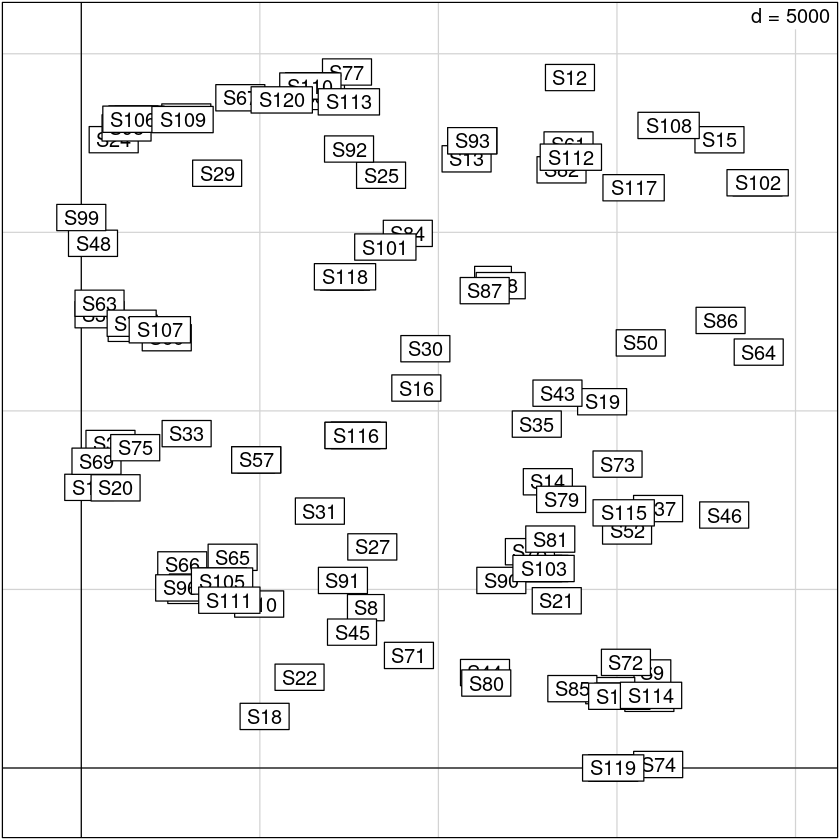

In [10]:
s.label(xyJit00)

Looks right.

Now we construct a neighbor matrix. Which means we have to define neighbors, and weight them. We'll use Delauney triangulation, because the jittering might accidentally cut-off connections to neighbors if we use the gabriel algorithm.

In [11]:
nb <- chooseCN(coordinates(xyJit00), type = 1, plot.nb = FALSE)
lw <- nb2listw(nb, style = 'S', zero.policy = TRUE) #"S" provided the widest variation weights.


Now we'll make deMEMs and select for those that seemed correlated with changes in the community matrix, all in one command:

In [26]:
mem.sel$summary

variables order R2         R2Cum      AdjR2Cum   pvalue
1  MEM8       8    0.03855364 0.03855364 0.03040579 0.001 
2  MEM10     10    0.03712305 0.07567669 0.05987629 0.002 
3  MEM23     23    0.01942416 0.09510085 0.07169828 0.027 
4  MEM40     40    0.01729982 0.11240067 0.08152765 0.031 
5  MEM27     27    0.01686634 0.12926701 0.09107697 0.030 
6  MEM15     15    0.01674096 0.14600797 0.10066326 0.035 
7  MEM3       3    0.01617468 0.16218265 0.10981907 0.029 
8  MEM4       4    0.01562012 0.17780277 0.11854531 0.034 
9  MEM46     46    0.01431904 0.19212181 0.12602269 0.048 
10 MEM1       1    0.01357760 0.20569941 0.13282779 0.050

In [25]:
mem.sel

$global.test
$global.test$obs
[1] 0.1610979

$global.test$pvalue
[1] 1e-04


$MEM.select
Orthobasis with 120 rows and 10 columns
Only 6 rows and 4 columns are shown
        MEM8       MEM10       MEM23      MEM40
1  0.4768060 -1.45476401 -1.06854759  0.5637744
2 -0.7393496  0.77175444  0.07601814  0.1070852
3 -0.7609796  0.75101098  0.31744406  0.8071277
4 -0.1068520  0.07466479  1.02878722 -0.3167281
5  0.4222950 -1.49093861 -0.32498314 -0.1362938
6 -0.2145895 -1.52788746  1.12720919 -0.4754798

$summary
   variables order         R2      R2Cum   AdjR2Cum pvalue
1       MEM8     8 0.03855364 0.03855364 0.03040579  0.001
2      MEM10    10 0.03712305 0.07567669 0.05987629  0.002
3      MEM23    23 0.01942416 0.09510085 0.07169828  0.027
4      MEM40    40 0.01729982 0.11240067 0.08152765  0.031
5      MEM27    27 0.01686634 0.12926701 0.09107697  0.030
6      MEM15    15 0.01674096 0.14600797 0.10066326  0.035
7       MEM3     3 0.01617468 0.16218265 0.10981907  0.029
8       MEM4     4 0.01562012 0.17780277 0.11854531  0.034
9      MEM46    46 0.01431904 0.19212181 0.12602269  0.048
10      MEM1     1 0.01357760 0.20569941 0.13282779  0.050

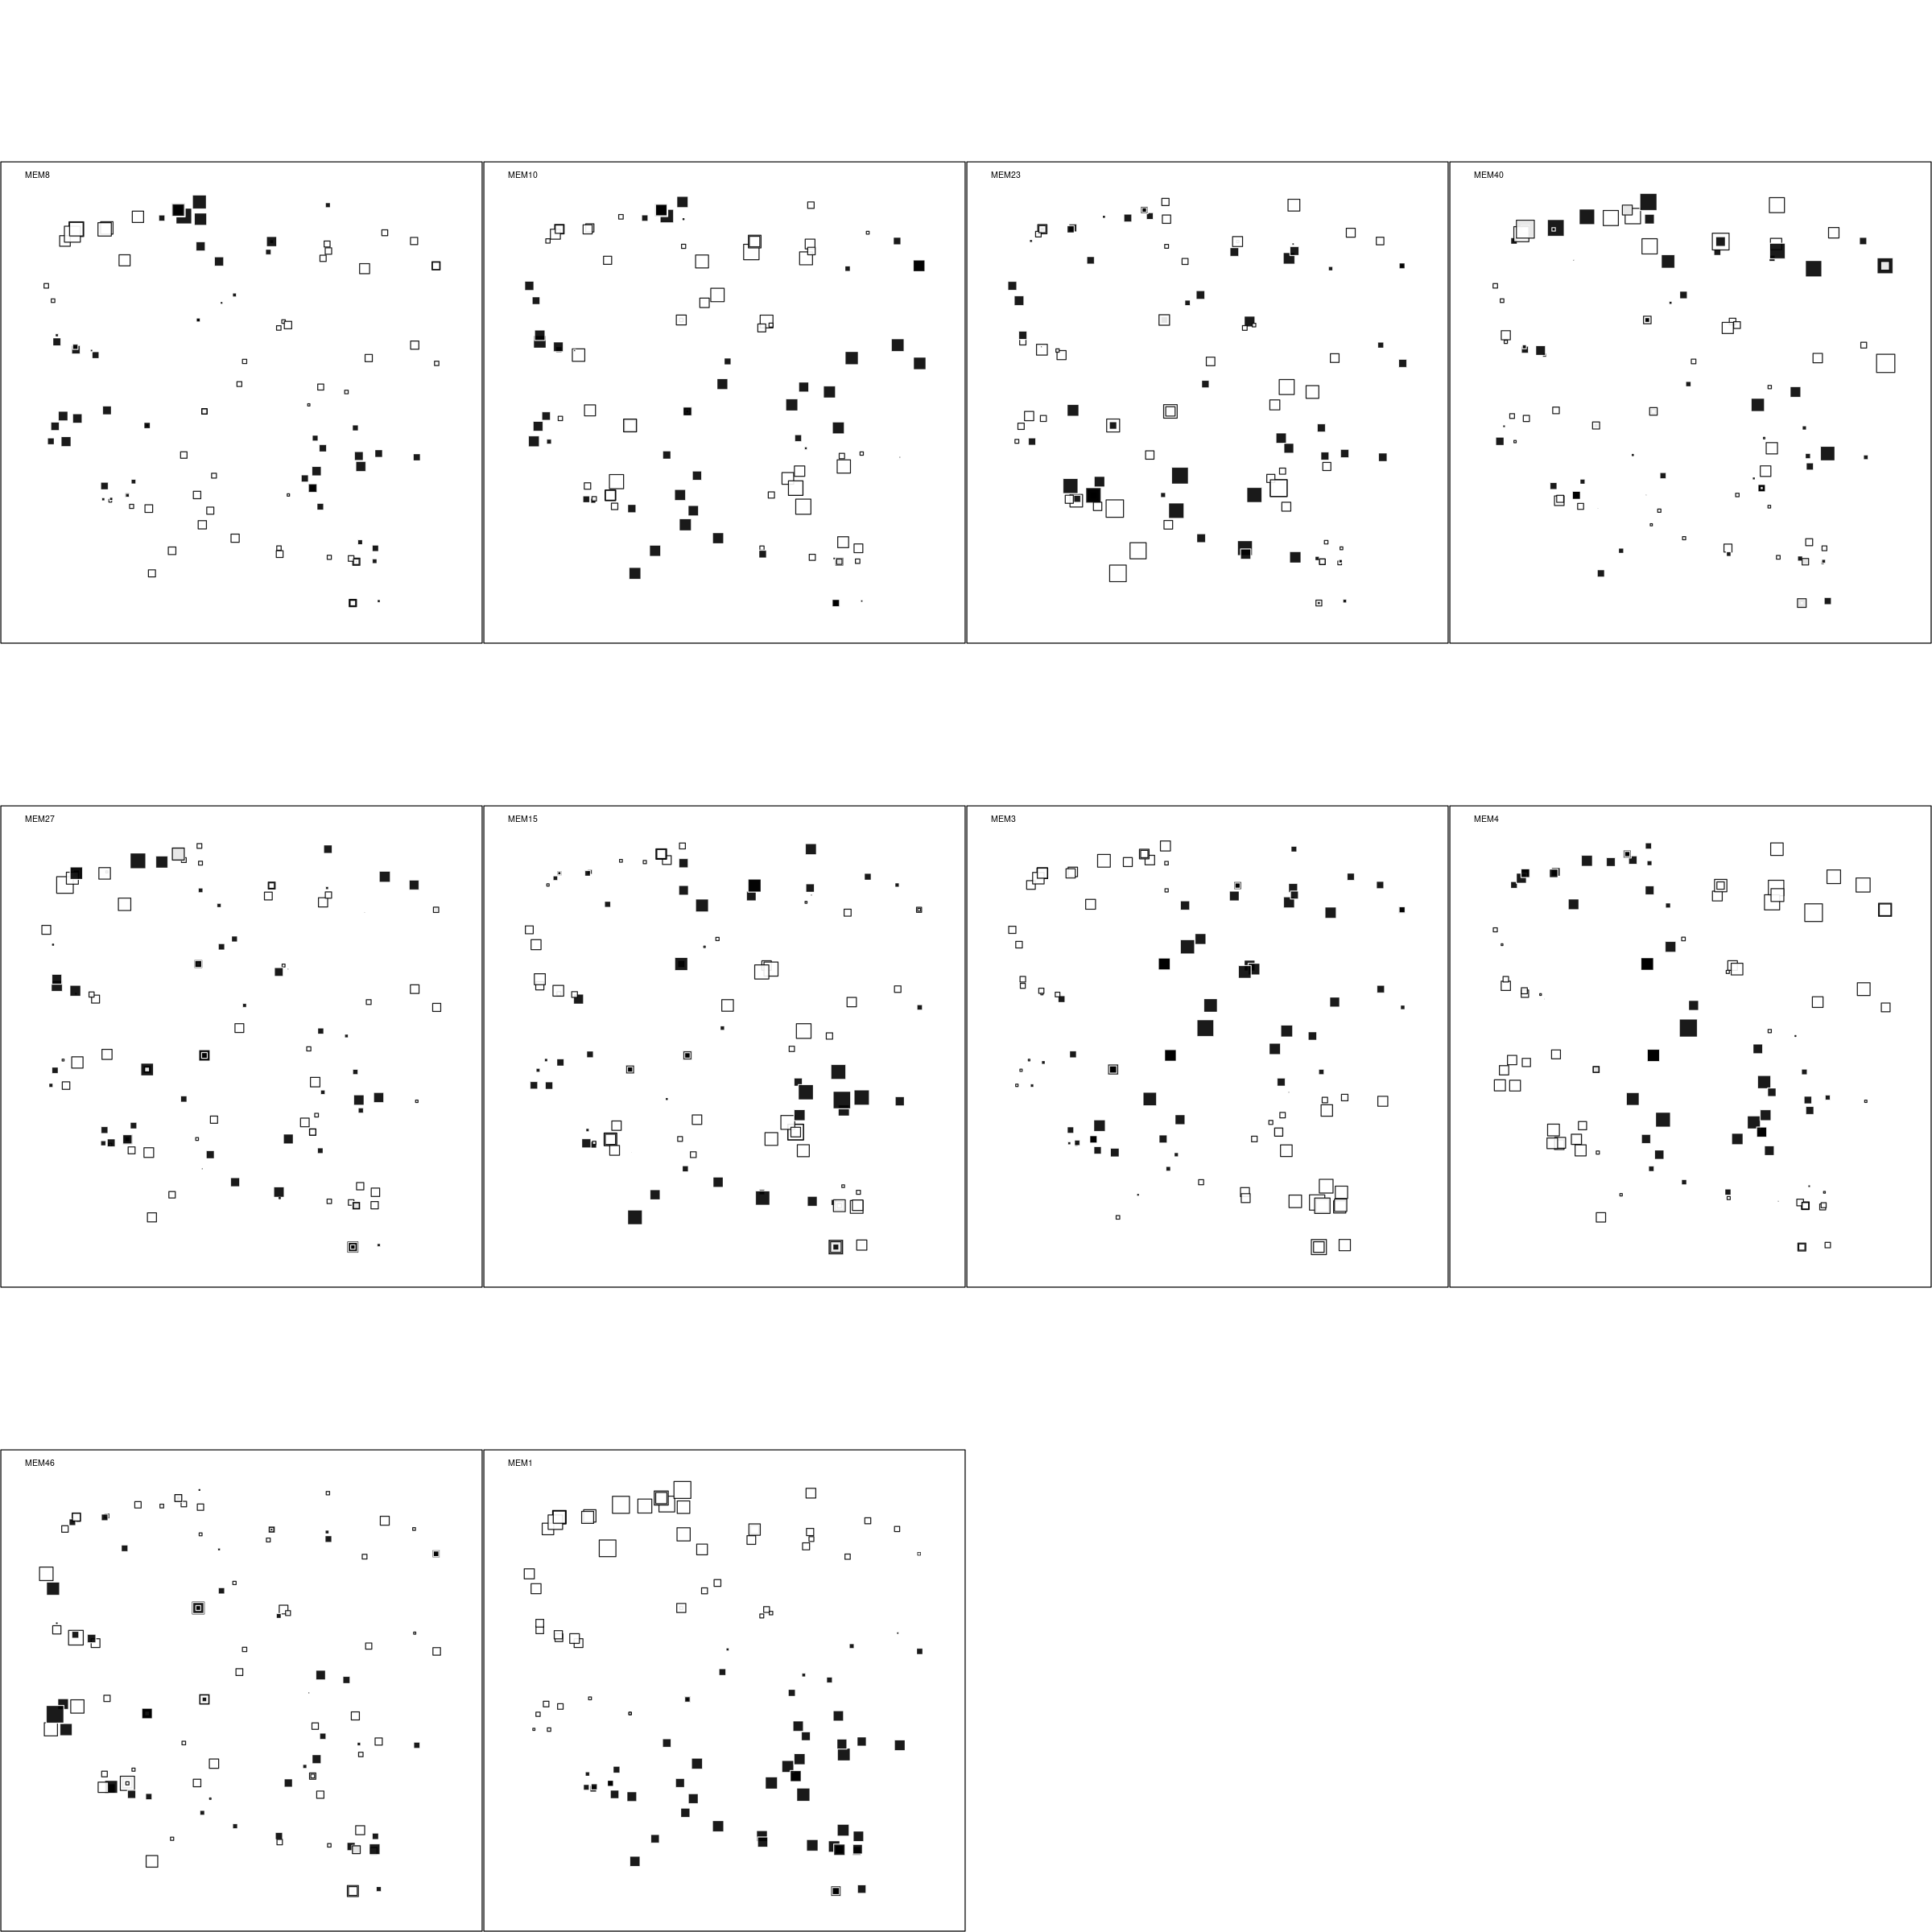

In [24]:
options(repr.plot.width=20, repr.plot.height=20)
plot(mem.sel$MEM.select, SpORcoords = xyJit00)

MEM10 and MEM3 looks correlated with the presence of central forest/mountain system. 

In [27]:
save(mem.sel, file="mems.rda")